# Project 4: Web Scraping Job Postings 

Fiona Dee - June 2021

---  

NOTE: I haven't uploaded the datafiles to public github, so this jupyter notebook is a static representation of the work I did for this project.


[Skip to Index](#index)   
[Skip to Overview of web scraping](#webscrape)  

---
---
<a id='executive_summary'></a>
### Executive Summary  

We want to attract the right hires – by being competitive and an employer of choice.  

Starting with analysis of how our competitors advertise for data-related job posts on Seek.com.au:  
- Data Scientists,  
- Data Specialists (Artificial Intelligence, Business Intelligence, Data Architect, Data Engineer, Machine Learning), and  
- Data Analysts.  

Only about a quarter of job posts have **salary** information, so Seek’s search filters for salary ranges were used to identify jobs landing in the various salary ranges: 0-80K, 80k-120k, 120k+. Many jobs were found to cut across multiple ranges, reflecting the ‘salary commensurate with experience’ attitude of many employers.  
- Low salary descriptors: graduate, junior, assistant, coordinator, phd.  
- High salary descriptors: director, professor, principal, .head of’.  
- Middle salary descriptors were not clear and reflects the job market where mid-level jobs with the same title and in the same industry can have significantly different salaries, even when performing the same roles.  

<div>
<img src="images/Salary-low-high-factors.png" width="700"/>
</div>
<br>  

When it comes to **job categories**, the job descriptions predicted the three job groups fairly well about 80% of the time. The top features of interest were:  
- Overall: science, data, computer science, intelligence, research.  
- Skill keywords were: research, python, sql, cloud, aws.  

<div>
<img src="images/Categories-top-20-factors.png" width="700"/>
</div>
<br> 

#### Recommendations for further research and analysis
We have examined how other employers advertise, but we haven’t assessed how effective their job postings are. While it is unlikely other companies will provide us with information about whether their job postings attracted the calibre of workers they were aiming for, it may be possible to infer good practices from adverts placed by larger companies who advertise frequently.

**_Overall limitations_** of this analysis:  
- Jobs were scraped from Seek at one point in time.  

Further analysis could be undertaken by comparing job postings over time.  

**_Limitations of salary analysis_** in this report:  
- Only compared jobs within the nominated fields of data-jobs.  
- Used attributes of: Job Title, Employment type, Industry and sub-classification to predict salary ranges.  

Further analysis could be undertaken by including Location or Location groups with the above attributes.

**_Limitations of job category analysis_** in this report:  
- Only compared jobs within the nominated fields of data-jobs.
- Only used Job Description to predict job category.  

Further analysis could be undertaken by including Industry with the above attribute, and/or by only analysing those Companies who advertise often.


---  
[Back to Executive Summary](#executive_summary)  
[Skip to index](#index)  
<a id='webscrape'></a>  
### Overview of web scrape & refining to the datasets for analysis  


**Scrape seek.com.au for specific job keywords in salary ranges**  
Then use unique Job IDs from consolidated search results to scrape for the details of jobs.

Spiders:
- joblist_wage_bracket_spider.py
- job_detail_spider.py

Keywords:
- Data Scientist
- Data Analyst
- Artificial Intelligence
- Business Intelligence
- Data Architect
- Data Engineer
- Machine Learning

Salary ranges:
- 0-80000
- 80000-100000
- 100000-120000
- 120000-999999

As expected, the scrape resulted in many duplicate jobs due to the overlapping nature of jobs across keywords and salary ranges, and the need to subset searches to keep within the 200 page limit of returned results.

**Load scraped data, prepare datasets and remove duplicates**  
Initial scrape of ~45k jobs from the search listing was prepared by linking each Job ID to all keyword and salary range searches it appeared in, so these could be used in EDA phase.

Joblist dataset then had duplicate Job IDs removed and compared with the Jobdetail dataset. Both datasets were reduced to their common Job IDs, ~15k.

**Reduce dataset to jobs-of-interest**  
Seek's search resulted in a number of non-relevant jobs being included near the end of the search-list, eg plumbers.

Removed jobs where classifications and sub-classifications had low number from the datasets to maximise the number of jobs-of-interest for analysis, ~12k. 


---
---
<a id='index'></a>
# Index

[Executive Summary](#executive_summary)  
[Overview of web scraping](#webscrape)  

 . - . - . - .

[Import statements](#import)  
[Define Functions](#functions)  
  
### Load data  
- [Load search joblists](#load)  
- [Save unique job IDs as input for job_detail spider](#unique_ids)  
- [Drop premium jobs, unneeded columns & duplicated rows](#premium)  
- [Link Job ID to all keyword and salary range searches it appeared in](#link_job_id)  
- [Load job details](#load_detail)  
- [Check if same job_ids in both joblist & jobdetail](#compare)  
<br>  

[Prepared datasets: load in from here](#load_prepared)  

- [Refine datasets](#refine)  

[Ready-to-use datasets: load in from here](#load_ready)  

### EDA  
- [EDA: Classification & SubClassification](#classification)  
- [EDA: location, loc_area, company](#location)  
- [EDA: Job Title](#title)  


### Models & Predictions
[Q1: Job Salary Factors](#q1)  
- [4 salary brackets](#4_salary_brackets)  
- [3 Salary Brackets](#3_salary_brackets)  
<br>  
  
[Q2: Job Category Factors](#q2)  
- [prepare predictor matrix](#q2_matrix)  
- [Q2 model](#q2_model)  


---
---
[back to index](#index)
<a id='import'></a>
## Import statements  
<br>


In [1]:
import pandas as pd
import numpy as np
import re
import string

from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline

# prevent $ from displaying as formatting markers
pd.set_option('display.html.use_mathjax', False)

# show all columns and rows
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report

from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

import scipy.stats as stats


In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from textblob import TextBlob, Word

In [4]:
# from six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# # import graphviz
# ########
# # plt.style.use('fivethirtyeight')

# from ipywidgets import *
# from IPython.display import display

---
[back to index](#index)

<a id='functions'></a>
## Define Functions
<br>


In [5]:
# plot a corner heatmap for correlation values
def plot_corr(data, size1=15, size2=10):
    ''' Plots a corner heatmap
    '''
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(data, dtype=bool))

    plt.figure(figsize=(size1, size2))
    
    sns.heatmap(
        data,
        cmap='vlag', #palette being used
        annot=True, #annotate each square
        mask=mask, #get rid of redundant info, need only one half of matrix
        vmin=-1.,
        vmax=1.,
        linewidths=.01
    )
    plt.title('Correlation matrix');

---
[back to index](#index)

<a id='load'></a>
## Load search joblists
<br>


In [6]:
# multiple Data Specialist searches
path_to_file1 = './datasets/joblist_20210619_DS-BI.jl'
path_to_file2 = './datasets/joblist_20210619_DAE-ML-AI.jl'

# Data Analyst searches
path_to_file_da1 = './datasets/joblist_20210619_DA-nsw.jl'
path_to_file_da2 = './datasets/joblist_20210619_DA-vic.jl'
path_to_file_da3 = './datasets/joblist_20210619_DA-other.jl'


### DS, BI, DArch, DE, ML, AI job searches

In [7]:
# load data onto dataframes - multiple Data Specialist searches

df1 = pd.read_json(path_to_file1, lines=True)
df2 = pd.read_json(path_to_file2, lines=True)

print(df1.shape, df2.shape)
df1.columns

(12159, 13) (8869, 13)


Index(['job_id', 'job_title', 'job_type', 'job_location', 'job_area',
       'job_class', 'job_subclass', 'job_desc', 'job_salary', 'search_job',
       'salary_bracket', 'search_page', 'search_loc'],
      dtype='object')

In [8]:
# combine into one dataframe
jobs_df = pd.concat([df1, df2], ignore_index=True, axis=0)
jobs_df.shape

# (21028, 13)

(21028, 13)

In [9]:
# check nulls
jobs_df.info()

## salary & area have nulls - as expected

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21028 entries, 0 to 21027
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   job_id          21028 non-null  int64 
 1   job_title       21028 non-null  object
 2   job_type        21028 non-null  object
 3   job_location    21028 non-null  object
 4   job_area        14220 non-null  object
 5   job_class       21028 non-null  object
 6   job_subclass    21028 non-null  object
 7   job_desc        21028 non-null  object
 8   job_salary      6928 non-null   object
 9   search_job      21028 non-null  object
 10  salary_bracket  21028 non-null  object
 11  search_page     21028 non-null  object
 12  search_loc      21028 non-null  object
dtypes: int64(1), object(12)
memory usage: 2.1+ MB


### Data Analyst job searches

In [10]:
# load data onto dataframes - Data Analyst searches

df_da1 = pd.read_json(path_to_file_da1, lines=True)
df_da2 = pd.read_json(path_to_file_da2, lines=True)
df_da3 = pd.read_json(path_to_file_da3, lines=True)

print(df_da1.shape, df_da2.shape, df_da3.shape)
df_da1.columns

(9955, 13) (7040, 13) (7335, 13)


Index(['job_id', 'job_title', 'job_type', 'job_location', 'job_area',
       'job_class', 'job_subclass', 'job_desc', 'job_salary', 'search_job',
       'salary_bracket', 'search_page', 'search_loc'],
      dtype='object')

In [11]:
# combine into one dataframe
jobs_da_df = pd.concat([df_da1, df_da2, df_da3], ignore_index=True, axis=0)
jobs_da_df.shape

# (24330, 13)

(24330, 13)

In [12]:
# check nulls
jobs_da_df.info()

## salary & area have nulls - as expected

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24330 entries, 0 to 24329
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   job_id          24330 non-null  int64 
 1   job_title       24330 non-null  object
 2   job_type        24330 non-null  object
 3   job_location    24330 non-null  object
 4   job_area        16440 non-null  object
 5   job_class       24330 non-null  object
 6   job_subclass    24330 non-null  object
 7   job_desc        24330 non-null  object
 8   job_salary      7875 non-null   object
 9   search_job      24330 non-null  object
 10  salary_bracket  24330 non-null  object
 11  search_page     24330 non-null  object
 12  search_loc      24330 non-null  object
dtypes: int64(1), object(12)
memory usage: 2.4+ MB


### Combine job searches

In [13]:
# combine into one dataframe
# many duplicated jobs due to overlapping key words & salary brackets searches

jobs_all_df = pd.concat([jobs_df, jobs_da_df], ignore_index=True, axis=0)
jobs_all_df.shape

# (45358, 13)

(45358, 13)

In [14]:
# check nulls
jobs_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45358 entries, 0 to 45357
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   job_id          45358 non-null  int64 
 1   job_title       45358 non-null  object
 2   job_type        45358 non-null  object
 3   job_location    45358 non-null  object
 4   job_area        30660 non-null  object
 5   job_class       45358 non-null  object
 6   job_subclass    45358 non-null  object
 7   job_desc        45358 non-null  object
 8   job_salary      14803 non-null  object
 9   search_job      45358 non-null  object
 10  salary_bracket  45358 non-null  object
 11  search_page     45358 non-null  object
 12  search_loc      45358 non-null  object
dtypes: int64(1), object(12)
memory usage: 4.5+ MB


---
[back to index](#index)

<a id='unique_ids'></a>
## Save unique job IDs as input for job_detail spider

*(only save .csv file once)*
<br>


In [15]:
# save unique job ids as input for job detail search
unique_jobs = pd.Series(jobs_all_df.job_id.unique())

In [16]:
# how many unique jobs are there?
len(unique_jobs)

## 15,430 large dataset to use for quesions 1 & 2
## can tailor dataset for each question to have better results from models

15430

In [17]:
# # save ids to file - break into batches for job_detail spider

# unique_jobs[:5100].to_csv("./links1.csv", index=False, header=False)
# unique_jobs[5100:10200].to_csv("./links2.csv", index=False, header=False)
# unique_jobs[10200:].to_csv("./links3.csv", index=False, header=False)

In [18]:
# # have a small batch to test with the job_detail spider

# unique_jobs[14000:15000].to_csv("./links_test.csv", index=False, header=False)

---
[back to index](#index)

<a id='premium'></a>
## Drop premium jobs, unneeded columns & duplicated rows


### Remove featured (premium) jobs

In [19]:
# check number of featured (premium) jobs - only want to analyse normalJobs
jobs_all_df.job_type.value_counts()

normalJob     44479
premiumJob      879
Name: job_type, dtype: int64

In [20]:
# reset the index prior identifying rows to drop by index
jobs_all_df.reset_index(drop=True, inplace=True)
jobs_all_df.head(2)

,job_id,job_title,job_type,job_location,job_area,job_class,job_subclass,job_desc,job_salary,search_job,salary_bracket,search_page,search_loc
0,52580219,Data Analyst/Developer,normalJob,Adelaide,None,Information & Communication Technology,Developers/Programmers,Establishing and maintaining robust data manag...,"$92,784 - $98,143",data-scientist,0-80k,salaryrange=0-80000,n/a
1,52580220,Data Analyst/Developer,normalJob,Adelaide,None,Government & Defence,Government - State,Establishing and maintaining robust data manag...,"$92,784 - $98,143",data-scientist,0-80k,salaryrange=0-80000,n/a


In [21]:
# identify all premiumJobs
drop_rows = jobs_all_df[jobs_all_df.job_type == 'premiumJob'].index

len(drop_rows)
# matches the number of premiumJobs

879

In [22]:
# check if premium jobs are duplicates of normal jobs
print(jobs_all_df[jobs_all_df.job_id == 52520660]['job_type'].value_counts())
jobs_all_df[jobs_all_df.job_id == 52520660].head(1)

## some premiumJobs aren't listed in the job search results,
## I'm ok with excluding them from this analysis

premiumJob    8
Name: job_type, dtype: int64


,job_id,job_title,job_type,job_location,job_area,job_class,job_subclass,job_desc,job_salary,search_job,salary_bracket,search_page,search_loc
969,52520660,Management Consultant,premiumJob,Sydney,"CBD, Inner West & Eastern Suburbs",Consulting & Strategy,Strategy & Planning,Are you looking your next career opportunity? ...,"$100,000 - $139,999",data-scientist,80k-10k0,page=6,n/a


In [23]:
# drop premiumJobs
jobs_all_df = jobs_all_df.drop(index=list(drop_rows))
jobs_all_df.shape

# (44479, 13)

(44479, 13)

In [24]:
# check number of premium jobs
jobs_all_df.job_type.value_counts()

# Good, only normalJobs now

normalJob    44479
Name: job_type, dtype: int64

In [25]:
# check number of unique job_ids
jobs_all_df.job_id.nunique()

## number of unique job_ids have dropped because some jobs were only listed as premiumJobs
## were only listed as premiumJobs

15412

### Remove unneeded columns

In [26]:
# current list of columns
jobs_all_df.columns

Index(['job_id', 'job_title', 'job_type', 'job_location', 'job_area',
       'job_class', 'job_subclass', 'job_desc', 'job_salary', 'search_job',
       'salary_bracket', 'search_page', 'search_loc'],
      dtype='object')

In [27]:
# unneeded columns for Q1&2
drop_cols = ['job_type', 'search_page', 'search_loc']
jobs_all_df.drop(columns=drop_cols, inplace=True)
jobs_all_df.shape

(44479, 10)

In [28]:
jobs_all_df.head(2)

,job_id,job_title,job_location,job_area,job_class,job_subclass,job_desc,job_salary,search_job,salary_bracket
0,52580219,Data Analyst/Developer,Adelaide,None,Information & Communication Technology,Developers/Programmers,Establishing and maintaining robust data manag...,"$92,784 - $98,143",data-scientist,0-80k
1,52580220,Data Analyst/Developer,Adelaide,None,Government & Defence,Government - State,Establishing and maintaining robust data manag...,"$92,784 - $98,143",data-scientist,0-80k


### Remove duplicates

In [29]:
# check how many duplicated rows
jobs_all_df.duplicated().value_counts()

## ~36k is more non-duplicated rows that I expected
## 'False' is the first occurence of a row and duplicates are 'True'

False    36272
True      8207
dtype: int64

In [30]:
# check how many duplicated job IDs
jobs_all_df.duplicated('job_id').value_counts()

## 'False' is the number of unique job_ids (~15k).
## Some cleanup to do in order to get to a joblist with only unique job_ids
## that also contains info about multiple brackets/searches for each job.

True     29067
False    15412
dtype: int64

In [31]:
# show a few duplicated rows
jobs_all_df[jobs_all_df.job_id.duplicated(keep=False)].sort_values(by='job_id').head(10)

## expecting duplicates but there is more than anticipated

,job_id,job_title,job_location,job_area,job_class,job_subclass,job_desc,job_salary,search_job,salary_bracket
5054,50028407,Study Director - Immunobiology,Adelaide,None,Science & Technology,Biological & Biomedical Sciences,You will be responsible for performing Scienti...,"$80,000 - $100,000 plus super",data-scientist,80k-10k0
3520,50028407,Study Director - Immunobiology,Adelaide,None,Science & Technology,Biological & Biomedical Sciences,You will be responsible for performing Scienti...,"$80,000 - $100,000 plus super",data-scientist,0-80k
3962,50028407,Study Director - Immunobiology,Adelaide,None,Science & Technology,Biological & Biomedical Sciences,You will be responsible for performing Scienti...,"$80,000 - $100,000 plus super",data-scientist,80k-10k0
40580,50028407,Study Director - Immunobiology,Adelaide,None,Science & Technology,Biological & Biomedical Sciences,You will be responsible for performing Scienti...,"$80,000 - $100,000 plus super",data-analyst,0-80k
40895,50028407,Study Director - Immunobiology,Adelaide,None,Science & Technology,Biological & Biomedical Sciences,You will be responsible for performing Scienti...,"$80,000 - $100,000 plus super",data-analyst,80k-10k0
4875,50028407,Study Director - Immunobiology,Adelaide,None,Science & Technology,Biological & Biomedical Sciences,You will be responsible for performing Scienti...,"$80,000 - $100,000 plus super",data-scientist,0-80k
4315,51160729,Microsoft Azure Senior to Managing Consultant-...,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,Consultants,This is an exciting opportunity to join a lead...,None,business-intelligence,10k0-120k
1570,51160729,Microsoft Azure Senior to Managing Consultant-...,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,Consultants,This is an exciting opportunity to join a lead...,None,data-scientist,10k0-120k
23823,51160729,Microsoft Azure Senior to Managing Consultant-...,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,Consultants,This is an exciting opportunity to join a lead...,None,data-analyst,10k0-120k
23860,51160729,Microsoft Azure Senior to Managing Consultant-...,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,Consultants,This is an exciting opportunity to join a lead...,None,data-analyst,120k-999999


In [32]:
## have a look at one of the duplicated jobs & see where the duplicates are coming from
jobs_df[jobs_df.job_id == 50028407]

## appropriate for it to be in both salary_brackets
## search results were displaying the job on multiple pages within Seek's results

,job_id,job_title,job_type,job_location,job_area,job_class,job_subclass,job_desc,job_salary,search_job,salary_bracket,search_page,search_loc
3520,50028407,Study Director - Immunobiology,normalJob,Adelaide,None,Science & Technology,Biological & Biomedical Sciences,You will be responsible for performing Scienti...,"$80,000 - $100,000 plus super",data-scientist,0-80k,page=23,n/a
3962,50028407,Study Director - Immunobiology,normalJob,Adelaide,None,Science & Technology,Biological & Biomedical Sciences,You will be responsible for performing Scienti...,"$80,000 - $100,000 plus super",data-scientist,80k-10k0,page=24,n/a
4875,50028407,Study Director - Immunobiology,normalJob,Adelaide,None,Science & Technology,Biological & Biomedical Sciences,You will be responsible for performing Scienti...,"$80,000 - $100,000 plus super",data-scientist,0-80k,page=30,n/a
5054,50028407,Study Director - Immunobiology,normalJob,Adelaide,None,Science & Technology,Biological & Biomedical Sciences,You will be responsible for performing Scienti...,"$80,000 - $100,000 plus super",data-scientist,80k-10k0,page=31,n/a


In [33]:
# drop duplicated rows & reset index
jobs_all_df.drop_duplicates(inplace=True, ignore_index=True)
print(jobs_all_df.shape)
jobs_all_df.head(2)

# (36272, 10)

(36272, 10)


,job_id,job_title,job_location,job_area,job_class,job_subclass,job_desc,job_salary,search_job,salary_bracket
0,52580219,Data Analyst/Developer,Adelaide,None,Information & Communication Technology,Developers/Programmers,Establishing and maintaining robust data manag...,"$92,784 - $98,143",data-scientist,0-80k
1,52580220,Data Analyst/Developer,Adelaide,None,Government & Defence,Government - State,Establishing and maintaining robust data manag...,"$92,784 - $98,143",data-scientist,0-80k


---
[back to index](#index)

<a id='link_job_id'></a>
## Link Job ID to all keyword and salary range searches it appeared in


### Dummy salary_bracket & search_job

In [34]:
# how balanced are the brackets?
jobs_all_df.salary_bracket.value_counts()

## looks fairly balanced at the moment - but there will be job_ids in multiple brackets
## '10k0' is meant to be '100k' - will fix header when in dummied columms


120k-999999    9874
10k0-120k      9634
80k-10k0       8759
0-80k          8005
Name: salary_bracket, dtype: int64

In [35]:
# how many jobs were returned by the various searches?
jobs_all_df.search_job.value_counts()

## unsurprisingly the majority came from the 'data analyst' search
## but there will be job_ids in multiple searches as well as multiple salary brackets


data-analyst               19583
data-scientist              5561
business-intelligence       3987
data-engineer               3064
machine-learning            2075
data-architect              1391
artificial-intelligence      611
Name: search_job, dtype: int64

In [36]:
# deliberately keeping all dummied columns
# will drop if needed when training models

joblist_dummies = pd.get_dummies(data=jobs_all_df,
                                columns=['salary_bracket', 'search_job'])
print(joblist_dummies.shape)
joblist_dummies.columns

(36272, 19)


Index(['job_id', 'job_title', 'job_location', 'job_area', 'job_class',
       'job_subclass', 'job_desc', 'job_salary', 'salary_bracket_0-80k',
       'salary_bracket_10k0-120k', 'salary_bracket_120k-999999',
       'salary_bracket_80k-10k0', 'search_job_artificial-intelligence',
       'search_job_business-intelligence', 'search_job_data-analyst',
       'search_job_data-architect', 'search_job_data-engineer',
       'search_job_data-scientist', 'search_job_machine-learning'],
      dtype='object')

In [37]:
# rename columns
joblist_dummies.rename(columns={
    'job_title': 'title', 
    'job_location': 'location', 
    'job_area': 'loc_area', 
    'job_class': 'classification',
    'job_subclass': 'class_sub', 
    'job_desc': 'desc_short', 
    'job_salary': 'salary', 
    'salary_bracket_0-80k': 'salary_0-80k',
    'salary_bracket_10k0-120k': 'salary_100-120k', 
    'salary_bracket_120k-999999': 'salary_120k_plus',
    'salary_bracket_80k-10k0': 'salary_80-100k', 
    'search_job_artificial-intelligence': 'search_AI',
    'search_job_business-intelligence': 'search_BI', 
    'search_job_data-analyst': 'search_DA',
    'search_job_data-architect': 'search_DArch', 
    'search_job_data-engineer': 'search_DE',
    'search_job_data-scientist': 'search_DS', 
    'search_job_machine-learning': 'search_ML'
    }, inplace=True)

joblist_dummies.head(2)

,job_id,title,location,loc_area,classification,class_sub,desc_short,salary,salary_0-80k,salary_100-120k,salary_120k_plus,salary_80-100k,search_AI,search_BI,search_DA,search_DArch,search_DE,search_DS,search_ML
0,52580219,Data Analyst/Developer,Adelaide,None,Information & Communication Technology,Developers/Programmers,Establishing and maintaining robust data manag...,"$92,784 - $98,143",1,0,0,0,0,0,0,0,0,1,0
1,52580220,Data Analyst/Developer,Adelaide,None,Government & Defence,Government - State,Establishing and maintaining robust data manag...,"$92,784 - $98,143",1,0,0,0,0,0,0,0,0,1,0


### Rollup counts of salary_bracket & search_job

In [38]:
# rollup rows so all dummied info is represented on one row per job_id
joblist_dummies = joblist_dummies.groupby('job_id', as_index=False).agg('sum')
joblist_dummies.shape

## matches number of unique job IDs
# (15412, 12)

(15412, 12)

In [39]:
# check on the job_id which had 4 rows
joblist_dummies[joblist_dummies.job_id == 50028407]

## the counts are correct, 
## but I only want to know *if* it appeared in a category, not how many times

,job_id,salary_0-80k,salary_100-120k,salary_120k_plus,salary_80-100k,search_AI,search_BI,search_DA,search_DArch,search_DE,search_DS,search_ML
0,50028407,2,0,0,2,0,0,2,0,0,2,0


In [40]:
# leave 0 & job_id as is, replace all other numbers with 1
joblist_dummies = joblist_dummies.applymap(lambda x: x if (x>10 or x<1) else 1)
print(joblist_dummies.shape)
joblist_dummies.head()

(15412, 12)


,job_id,salary_0-80k,salary_100-120k,salary_120k_plus,salary_80-100k,search_AI,search_BI,search_DA,search_DArch,search_DE,search_DS,search_ML
0,50028407,1,0,0,1,0,0,1,0,0,1,0
1,51160729,0,1,1,0,0,1,1,0,1,1,0
2,51218194,0,0,1,0,0,0,0,0,1,0,0
3,51390969,1,0,0,0,0,0,1,0,0,0,0
4,51461250,0,1,0,0,0,0,1,0,0,0,0


### Add summary columns

In [41]:
joblist_dummies['bracket_count'] = (joblist_dummies['salary_0-80k']
                                   + joblist_dummies['salary_80-100k']
                                   + joblist_dummies['salary_100-120k']
                                   + joblist_dummies['salary_120k_plus']
                                  )
joblist_dummies.bracket_count.value_counts()
## reasonable for jobs to go across 2 or 3 brackets
## no usual job salary range should go across 4 brackets
## 7741 jobs in one bracket >> this could be the dataset to use for predicting salary group

1    7741
2    5676
3    1995
Name: bracket_count, dtype: int64

In [42]:
joblist_dummies['search_count'] = (joblist_dummies['search_AI']
                                   + joblist_dummies['search_BI']
                                   + joblist_dummies['search_DA']
                                   + joblist_dummies['search_DArch']
                                   + joblist_dummies['search_DE']
                                   + joblist_dummies['search_DS']
                                   + joblist_dummies['search_ML']
                                  )
joblist_dummies.search_count.value_counts()
## expected some jobs to appear in multiple categories
## surprised there's so many across 5-7 categories

1    11126
2     2524
3      735
4      430
5      407
6      178
7       12
Name: search_count, dtype: int64

In [43]:
# what does one of those jobs across all searches look like?
jobs_all_df[jobs_all_df['job_id'] == 
               list(joblist_dummies[joblist_dummies.search_count ==7]
                    .job_id)[0]].job_desc[2092]

## yeah, probably going to cull those sort of jobs out later

"We're looking for Data Consultants across all levels to join our brand new office in Perth!"

### Consolidate joblist & dummies (salary_bracket & search_job)


In [44]:
# check joblist dataframe
print(jobs_all_df.shape)
print(len(jobs_all_df.job_id.unique()))
jobs_all_df.columns

## will need to remove duplicates before consolidating

(36272, 10)
15412


Index(['job_id', 'job_title', 'job_location', 'job_area', 'job_class',
       'job_subclass', 'job_desc', 'job_salary', 'search_job',
       'salary_bracket'],
      dtype='object')

In [45]:
# check dummies dataframe
print(joblist_dummies.shape)
joblist_dummies.columns

## reorder columns after joining datasets

(15412, 14)


Index(['job_id', 'salary_0-80k', 'salary_100-120k', 'salary_120k_plus',
       'salary_80-100k', 'search_AI', 'search_BI', 'search_DA', 'search_DArch',
       'search_DE', 'search_DS', 'search_ML', 'bracket_count', 'search_count'],
      dtype='object')

In [46]:
# new dataframe for combined data, only selected columns from jobs_all_df
# remove duplicates
joblist_df = jobs_all_df.loc[:,['job_id', 'job_title', 'job_location', 'job_area', 'job_class',
       'job_subclass', 'job_desc', 'job_salary']]
print('joblist_df.shape before removing duplicates:', joblist_df.shape)
joblist_df.drop_duplicates(inplace=True)
print('joblist_df.shape AFTER removing duplicates:', joblist_df.shape)


joblist_df.shape before removing duplicates: (36272, 8)
joblist_df.shape AFTER removing duplicates: (15412, 8)


In [47]:
# merge dataframes
joblist_df = joblist_df.merge(joblist_dummies, on='job_id')
print(joblist_df.shape)
print(joblist_df.columns)
joblist_df.head(3)

(15412, 21)
Index(['job_id', 'job_title', 'job_location', 'job_area', 'job_class',
       'job_subclass', 'job_desc', 'job_salary', 'salary_0-80k',
       'salary_100-120k', 'salary_120k_plus', 'salary_80-100k', 'search_AI',
       'search_BI', 'search_DA', 'search_DArch', 'search_DE', 'search_DS',
       'search_ML', 'bracket_count', 'search_count'],
      dtype='object')


,job_id,job_title,job_location,job_area,job_class,job_subclass,job_desc,job_salary,salary_0-80k,salary_100-120k,salary_120k_plus,salary_80-100k,search_AI,search_BI,search_DA,search_DArch,search_DE,search_DS,search_ML,bracket_count,search_count
0,52580219,Data Analyst/Developer,Adelaide,None,Information & Communication Technology,Developers/Programmers,Establishing and maintaining robust data manag...,"$92,784 - $98,143",1,0,0,1,0,1,1,0,1,1,0,2,4
1,52580220,Data Analyst/Developer,Adelaide,None,Government & Defence,Government - State,Establishing and maintaining robust data manag...,"$92,784 - $98,143",1,0,0,1,0,1,1,0,1,1,0,2,4
2,52609378,Data Scientist,Sydney,None,Information & Communication Technology,Other,Seeking a Data Scientist to be involved in a r...,None,1,0,0,0,0,0,1,0,1,1,1,1,4


In [48]:
# reorder the dummy & summary columns
joblist_df = joblist_df[['job_id', 'job_title', 'job_location', 'job_area', 'job_class',
                   'job_subclass', 'job_desc', 'job_salary',
                   'bracket_count',
                   'salary_0-80k','salary_80-100k','salary_100-120k','salary_120k_plus', 
                   'search_AI','search_BI', 'search_DArch', 'search_DE','search_ML',
                   'search_DA','search_DS','search_count',]]
joblist_df.head(2)
## opps renamed multiple columns in the dummies df, but didn't in the original 

,job_id,job_title,job_location,job_area,job_class,job_subclass,job_desc,job_salary,bracket_count,salary_0-80k,salary_80-100k,salary_100-120k,salary_120k_plus,search_AI,search_BI,search_DArch,search_DE,search_ML,search_DA,search_DS,search_count
0,52580219,Data Analyst/Developer,Adelaide,None,Information & Communication Technology,Developers/Programmers,Establishing and maintaining robust data manag...,"$92,784 - $98,143",2,1,1,0,0,0,1,0,1,0,1,1,4
1,52580220,Data Analyst/Developer,Adelaide,None,Government & Defence,Government - State,Establishing and maintaining robust data manag...,"$92,784 - $98,143",2,1,1,0,0,0,1,0,1,0,1,1,4


In [49]:
# rename columns
joblist_df.rename(columns={
    'job_title': 'title', 
    'job_location': 'location', 
    'job_area': 'loc_area', 
    'job_class': 'classification',
    'job_subclass': 'class_sub', 
    'job_desc': 'desc_short', 
    'job_salary': 'salary'
    }, inplace=True)

joblist_df.head(2)

,job_id,title,location,loc_area,classification,class_sub,desc_short,salary,bracket_count,salary_0-80k,salary_80-100k,salary_100-120k,salary_120k_plus,search_AI,search_BI,search_DArch,search_DE,search_ML,search_DA,search_DS,search_count
0,52580219,Data Analyst/Developer,Adelaide,None,Information & Communication Technology,Developers/Programmers,Establishing and maintaining robust data manag...,"$92,784 - $98,143",2,1,1,0,0,0,1,0,1,0,1,1,4
1,52580220,Data Analyst/Developer,Adelaide,None,Government & Defence,Government - State,Establishing and maintaining robust data manag...,"$92,784 - $98,143",2,1,1,0,0,0,1,0,1,0,1,1,4


In [50]:
# check dataframe
joblist_df.info()

## will need to change job_id into object, but later is fine

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15412 entries, 0 to 15411
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_id            15412 non-null  int64 
 1   title             15412 non-null  object
 2   location          15412 non-null  object
 3   loc_area          10186 non-null  object
 4   classification    15412 non-null  object
 5   class_sub         15412 non-null  object
 6   desc_short        15412 non-null  object
 7   salary            4975 non-null   object
 8   bracket_count     15412 non-null  int64 
 9   salary_0-80k      15412 non-null  int64 
 10  salary_80-100k    15412 non-null  int64 
 11  salary_100-120k   15412 non-null  int64 
 12  salary_120k_plus  15412 non-null  int64 
 13  search_AI         15412 non-null  int64 
 14  search_BI         15412 non-null  int64 
 15  search_DArch      15412 non-null  int64 
 16  search_DE         15412 non-null  int64 
 17  search_ML   

---
[back to index](#index)

<a id='load_detail'></a>
## Load job details
<br>


In [51]:
# multiple batches
path_to_file_detail1 = './datasets/jobdetail_20210619_links1.jl'
path_to_file_detail2 = './datasets/jobdetail_20210619_links2.jl'
path_to_file_detail3 = './datasets/jobdetail_20210619_links3.jl'

In [52]:
# load data onto dataframes

df1 = pd.read_json(path_to_file_detail1, lines=True)
df2 = pd.read_json(path_to_file_detail2, lines=True)
df3 = pd.read_json(path_to_file_detail3, lines=True)

print(df1.shape, df2.shape, df3.shape)
df1.columns

(5099, 6) (5094, 6) (5226, 6)


Index(['job_id', 'job_title', 'job_company', 'job_salary', 'job_type',
       'job_details'],
      dtype='object')

In [53]:
# combine into one dataframe & reset index
jobdetail_df = pd.concat([df1, df2, df3], ignore_index=True, axis=0)
print(jobdetail_df.shape)
jobdetail_df.head(2)

## salary had data filled in from job_type when there wasn't a salary listed

(15419, 6)


,job_id,job_title,job_company,job_salary,job_type,job_details
0,52600187,Data Analyst,Bet Technology,Full Time,Full Time,Overview Bet Technology provides state of the ...
1,52551231,Data Analyst,MedicalDirector,Full Time,Full Time,MedicalDirector is one of the leading provider...


In [54]:
# clear job_salary where it's the same as job_type
for i in range(0,len(jobdetail_df.job_id)):
    if jobdetail_df.job_salary[i] == jobdetail_df.job_type[i]:
        jobdetail_df.loc[i, 'job_salary'] = None
jobdetail_df.info()

## number of nulls in salary looks reasonable - not many jobs specify a salary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15419 entries, 0 to 15418
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   job_id       15419 non-null  int64 
 1   job_title    15419 non-null  object
 2   job_company  15419 non-null  object
 3   job_salary   4977 non-null   object
 4   job_type     15419 non-null  object
 5   job_details  15419 non-null  object
dtypes: int64(1), object(5)
memory usage: 722.9+ KB


In [55]:
# check employment type
jobdetail_df.job_type.value_counts()

## exclude 'Part Time' & 'Casual/Vacation' job types from this analysis

Full Time          11605
Contract/Temp       3320
Part Time            378
Casual/Vacation      116
Name: job_type, dtype: int64

In [56]:
# identify rows to drop
drop_rows = jobdetail_df[(jobdetail_df.job_type == 'Part Time') 
                         | (jobdetail_df.job_type == 'Casual/Vacation')].index

len(drop_rows)
## 378 + 116 = 494

494

In [57]:
# drop 'Part Time' & 'Casual/Vacation' job types
jobdetail_df = jobdetail_df.drop(index=list(drop_rows))
jobdetail_df.reset_index(drop=True, inplace=True)
print(jobdetail_df.shape)
jobdetail_df.job_type.value_counts()

## correct counts after dropping rows

(14925, 6)


Full Time        11605
Contract/Temp     3320
Name: job_type, dtype: int64

In [58]:
# check nulls
jobdetail_df.info()

## as expected, % of salary coverage is similar to joblist_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14925 entries, 0 to 14924
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   job_id       14925 non-null  int64 
 1   job_title    14925 non-null  object
 2   job_company  14925 non-null  object
 3   job_salary   4828 non-null   object
 4   job_type     14925 non-null  object
 5   job_details  14925 non-null  object
dtypes: int64(1), object(5)
memory usage: 699.7+ KB


In [59]:
# rename columns
jobdetail_df.rename(columns={
    'job_title': 'title', 
    'job_company': 'company', 
    'job_salary': 'salary',
    'job_type': 'employ_type', 
    'job_details': 'desc_full', 
    }, inplace=True)

jobdetail_df.head(2)

,job_id,title,company,salary,employ_type,desc_full
0,52600187,Data Analyst,Bet Technology,None,Full Time,Overview Bet Technology provides state of the ...
1,52551231,Data Analyst,MedicalDirector,None,Full Time,MedicalDirector is one of the leading provider...


In [60]:
# check desc_full for a row
jobdetail_df.loc[0,'desc_full']

## yep, full job description was scraped

'Overview Bet Technology provides state of the art technology unrivalled in terms of speed and scalability for the betting industry in Australia and overseas. We are seeking a Data Analyst who will be working directly with our Research and Development Team to achieve key company objectives, as part of a small and quickly growing team. This is a multi-disciplinary role, best summarized as 50% data analytics & visualisation; 30% data warehousing; 20% CRM specialist. You will be an ambitious and passionate individual who wants to develop within a role, while being accountable for key components of a fast growth business that continues to break ground in an exciting industry. You will also be undertaking detailed analysis to support the Research and Development Plan, testing a range of hypothesis to help further the organisation in making data driven decisions for current & future projects. The Candidate You should have a degree or similar higher education qualification in a relevant subje

---
[back to index](#index)

<a id='compare'></a>
## Check if same job_ids in both joblist & jobdetail
<br>


In [61]:
# take the list of job_ids in joblist
compare_joblist = pd.DataFrame(joblist_df.job_id.unique())
compare_joblist.rename(columns={0:'joblist'}, inplace=True)
compare_joblist = compare_joblist.astype('object')
compare_joblist.shape

(15412, 1)

In [62]:
# take the list of job_ids in jobdetail
compare_jobdetail = pd.DataFrame(jobdetail_df.job_id.unique())
compare_jobdetail.rename(columns={0:'jobdetail'}, inplace=True)
compare_jobdetail = compare_jobdetail.astype(object)
compare_jobdetail.shape

(14925, 1)

In [63]:
# outer join lists to find job_ids which aren't in each other's list
difference = pd.merge(compare_jobdetail, compare_joblist, how='outer',
                        left_on='jobdetail', right_on='joblist')

difference.isna().value_counts()

## difference mostly due to employment type or premiumJob which was removed, 
## match tables to keep details of the same 14908 jobs

jobdetail  joblist
False      False      14908
True       False        504
False      True          17
dtype: int64

In [64]:
# show job_ids which aren't in respective lists
difference[difference.jobdetail.isna() | difference.joblist.isna()]

,jobdetail,joblist
504,52520660,NaN
535,52380706,NaN
1017,52584175,NaN
1381,52454375,NaN
2863,52387380,NaN
4954,52590809,NaN
4971,52483106,NaN
5006,52363655,NaN
5070,52487570,NaN
5082,52380219,NaN


In [65]:
# drop rows from joblist
drop_rows = list(difference[difference.jobdetail.isna()].joblist)
print('before: \n', joblist_df.job_id.isin(drop_rows).value_counts())
joblist_df.drop(index=joblist_df[joblist_df.job_id.isin(drop_rows)].index,
               inplace=True)
joblist_df.reset_index(drop=True, inplace=True)
print('\nshape afterwards: ', joblist_df.shape, '\n')
joblist_df.info()

before: 
 False    14908
True       504
Name: job_id, dtype: int64

shape afterwards:  (14908, 21) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14908 entries, 0 to 14907
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_id            14908 non-null  int64 
 1   title             14908 non-null  object
 2   location          14908 non-null  object
 3   loc_area          9860 non-null   object
 4   classification    14908 non-null  object
 5   class_sub         14908 non-null  object
 6   desc_short        14908 non-null  object
 7   salary            4822 non-null   object
 8   bracket_count     14908 non-null  int64 
 9   salary_0-80k      14908 non-null  int64 
 10  salary_80-100k    14908 non-null  int64 
 11  salary_100-120k   14908 non-null  int64 
 12  salary_120k_plus  14908 non-null  int64 
 13  search_AI         14908 non-null  int64 
 14  search_BI         14908 non-null  int64 
 15  sea

In [66]:
# drop rows from jobdetail
drop_rows = list(difference[difference.joblist.isna()].jobdetail)
print('before: \n', jobdetail_df.job_id.isin(drop_rows).value_counts())
jobdetail_df.drop(index=jobdetail_df[jobdetail_df.job_id.isin(drop_rows)].index,
                  inplace=True)
jobdetail_df.reset_index(drop=True, inplace=True)
print('\nshape afterwards: ', jobdetail_df.shape, '\n')
jobdetail_df.info()

before: 
 False    14908
True        17
Name: job_id, dtype: int64

shape afterwards:  (14908, 6) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14908 entries, 0 to 14907
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   job_id       14908 non-null  int64 
 1   title        14908 non-null  object
 2   company      14908 non-null  object
 3   salary       4822 non-null   object
 4   employ_type  14908 non-null  object
 5   desc_full    14908 non-null  object
dtypes: int64(1), object(5)
memory usage: 698.9+ KB


In [67]:
# save dataframes
joblist_df.to_csv('./datasets/prepared_joblist_dataframe.csv', index=False)
jobdetail_df.to_csv('./datasets/prepared_jobdetail_dataframe.csv', index=False)

---
[back to index](#index)

<a id='load_prepared'></a>
## Prepared datasets: load in from here

So that I don't have to keep re-running the first part of this notebook. I've saved a version of the prepared datasets to load in at this point.

<br>

In [68]:
joblist_df = pd.read_csv('./datasets/prepared_joblist_dataframe.csv')
joblist_df['job_id'] = joblist_df['job_id'].astype('object')
joblist_df.info()
## need to change job_id to a string, don't want it being treated as a number
## easier to change one column dtype than specify all columns in read statement


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14908 entries, 0 to 14907
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_id            14908 non-null  object
 1   title             14908 non-null  object
 2   location          14908 non-null  object
 3   loc_area          9860 non-null   object
 4   classification    14908 non-null  object
 5   class_sub         14908 non-null  object
 6   desc_short        14908 non-null  object
 7   salary            4818 non-null   object
 8   bracket_count     14908 non-null  int64 
 9   salary_0-80k      14908 non-null  int64 
 10  salary_80-100k    14908 non-null  int64 
 11  salary_100-120k   14908 non-null  int64 
 12  salary_120k_plus  14908 non-null  int64 
 13  search_AI         14908 non-null  int64 
 14  search_BI         14908 non-null  int64 
 15  search_DArch      14908 non-null  int64 
 16  search_DE         14908 non-null  int64 
 17  search_ML   

In [69]:
jobdetail_df = pd.read_csv('./datasets/prepared_jobdetail_dataframe.csv')
jobdetail_df['job_id'] = jobdetail_df['job_id'].astype('object')
jobdetail_df.info()
## need to change job_id to a string, don't want it being treated as a number
## easier to change one column dtype than specify all columns  in read statement


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14908 entries, 0 to 14907
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   job_id       14908 non-null  object
 1   title        14908 non-null  object
 2   company      14908 non-null  object
 3   salary       4818 non-null   object
 4   employ_type  14908 non-null  object
 5   desc_full    14908 non-null  object
dtypes: object(6)
memory usage: 698.9+ KB


---
[back to index](#index)

<a id='refine'></a>
## Refine datasets 

**Goal:** Maximise the number of jobs-of-interest in the dataset. Seek's search resulted in a number of non-relevant jobs being included near the end of the search-list, eg plumbers.

**Assumption:** low job counts for Classification and Sub-classification are associated with the search's noise, i.e. low value matches to the search keywords.  
<br>

In [70]:
# How many classifications are there in the initial dataset?
print(joblist_df.classification.nunique())
joblist_df.classification.value_counts()

## 30 is reasonable, but there is a number that don't look directly relevant to core jobs-of-interest, e.g. Trades & Services

30


Information & Communication Technology    6440
Marketing & Communications                1206
Government & Defence                       936
Accounting                                 862
Banking & Financial Services               794
Healthcare & Medical                       487
Education & Training                       477
Science & Technology                       357
Sales                                      345
Human Resources & Recruitment              339
Manufacturing, Transport & Logistics       338
Mining, Resources & Energy                 333
Consulting & Strategy                      329
Engineering                                322
Administration & Office Support            235
Community Services & Development           129
Insurance & Superannuation                 124
Advertising, Arts & Media                  113
Construction                               101
Real Estate & Property                     101
Trades & Services                           93
Call Centre &

In [71]:
# How many sub classifications are there in the initial dataset?
print(joblist_df.class_sub.nunique())
joblist_df.class_sub.value_counts()

## 290 seems a lot, try to cull into a subset that is more relevant for jobs-of-interest

290


Business/Systems Analysts                          1500
Other                                              1166
Developers/Programmers                             1057
Engineering - Software                              695
Analysis & Reporting                                668
Architects                                          537
Digital & Search Marketing                          510
Government - Federal                                430
Consultants                                         402
Management                                          342
Database Development & Administration               331
Testing & Quality Assurance                         287
Government - State                                  278
Programme & Project Management                      233
Security                                            222
Product Management & Development                    191
Help Desk & IT Support                              190
Compliance & Risk                               

In [72]:
# assume that relatively rare sub-classifications don't have core characteristics of the jobs we're interested in
# find the sub-classifications where count > 30
highcount_class_sub = joblist_df.class_sub.value_counts() >30
highcount_class_sub = highcount_class_sub[highcount_class_sub == 1].index.tolist()

print(len(highcount_class_sub))
highcount_class_sub[:10]

## 71 sub-class looks like a better number and the top sub-classifications look relevant

71


['Business/Systems Analysts',
 'Other',
 'Developers/Programmers',
 'Engineering - Software',
 'Analysis & Reporting',
 'Architects',
 'Digital & Search Marketing',
 'Government - Federal',
 'Consultants',
 'Management']

In [73]:
# reduce dataset to jobs-of-interest
joblist_of_interest = joblist_df[joblist_df.class_sub.isin(highcount_class_sub)].copy()
joblist_of_interest.shape

## original number of unique job ids = 14908
## reduced number of unique job ids = 12947
## as expected, the low frequency sub classifications only accounted for a relatively small number of jobs

(12947, 21)

In [74]:
# show count of classification/sub-classification
joblist_of_interest.groupby(['classification','class_sub']).count()['job_id'].sort_values(ascending=False)

## there's likely to be more jobs to cull at the lower end of this list

classification                          class_sub                                     
Information & Communication Technology  Business/Systems Analysts                         1500
                                        Developers/Programmers                            1057
                                        Engineering - Software                             695
                                        Architects                                         537
Marketing & Communications              Digital & Search Marketing                         510
Government & Defence                    Government - Federal                               430
Information & Communication Technology  Consultants                                        402
                                        Other                                              346
                                        Database Development & Administration              331
                                        Testing & Quality 

In [75]:
# look at classification 'Trades & Services', it seems irrelevant to Data jobs
print('number of T&S jobs:', joblist_of_interest[joblist_of_interest.classification == 'Trades & Services'].shape[0])
joblist_of_interest[(joblist_of_interest.classification == 'Trades & Services') & (joblist_of_interest.search_count >1)]

## classification 'Trades & Services' is generally outside of jobs-of-interest, 
## but there are some which are relevant

number of T&S jobs: 12


,job_id,title,location,loc_area,classification,class_sub,desc_short,salary,bracket_count,salary_0-80k,salary_80-100k,salary_100-120k,salary_120k_plus,search_AI,search_BI,search_DArch,search_DE,search_ML,search_DA,search_DS,search_count
80,52558527,Head of Business Intelligence,Sydney,NaN,Trades & Services,Other,"OUR STORYFounded in Sydney in 2017, we saw the...","$100,000 - 200,000 per year",3,0,1,1,1,0,1,0,0,0,1,0,2


In [76]:
# is there a way to cull those which are <30 on the above groupby AND only appears in one search?

# find the low frequency not-relevant jobs in the class/sub-class groupby
not_relevant = joblist_of_interest.groupby(['classification','class_sub']).count()['job_id'] <30
not_relevant = pd.DataFrame(not_relevant[not_relevant==1])
not_relevant.reset_index(inplace=True)
not_relevant.drop(columns='job_id', inplace=True)
not_relevant

## most of these don't look like jobs-of-interest
## not worth time refining further, use this list to cull main dataset

,classification,class_sub
0,Accounting,Compliance & Risk
1,Accounting,Management
2,Accounting,Other
3,Accounting,Strategy & Planning
4,Administration & Office Support,Other
5,"Advertising, Arts & Media",Management
6,"Advertising, Arts & Media",Other
7,Banking & Financial Services,Account & Relationship Management
8,Banking & Financial Services,Management
9,CEO & General Management,Other


In [77]:
# how many jobs are not-relevant?
joblist_of_interest[joblist_of_interest.classification.isin(not_relevant.classification) & 
                    joblist_of_interest.class_sub.isin(not_relevant.class_sub)].shape

## another ~1k not-relevant jobs to drop from the dataset
## but if they appear in multiple job searches then they are more likely to be relevant

(998, 21)

In [78]:
# find not-relevant jobs which only appear in one search from the dataset
drop_rows = joblist_of_interest[(joblist_of_interest.classification.isin(not_relevant.classification)) 
                                & (joblist_of_interest.class_sub.isin(not_relevant.class_sub)) 
                                & (joblist_of_interest.search_count == 1)].index
len(drop_rows)
## as expected, most are only in 1 search and only a few appear in multiple searches

838

In [79]:
# remove not-relevant jobs which only appear in one search from the dataset
joblist_of_interest.drop(index=drop_rows, inplace=True, errors='ignore')
joblist_of_interest.shape

# (12109, 21)

(12109, 21)

In [80]:
# what are the characterists of the dataset: classifications
joblist_of_interest.classification.value_counts()

## some still look unrelated, but will let models look at them

Information & Communication Technology    6393
Marketing & Communications                1088
Government & Defence                       925
Accounting                                 671
Banking & Financial Services               438
Education & Training                       385
Healthcare & Medical                       326
Science & Technology                       285
Consulting & Strategy                      271
Sales                                      214
Manufacturing, Transport & Logistics       192
Mining, Resources & Energy                 182
Human Resources & Recruitment              180
Engineering                                139
Administration & Office Support            125
Insurance & Superannuation                  48
Real Estate & Property                      42
Design & Architecture                       41
Call Centre & Customer Service              41
Advertising, Arts & Media                   38
Retail & Consumer Products                  34
Legal        

In [81]:
# what are the characterists of the dataset: sub-classifications
joblist_of_interest.class_sub.value_counts()

## some still look unrelated, but will let models look at them

Business/Systems Analysts                         1500
Developers/Programmers                            1057
Other                                              858
Engineering - Software                             695
Analysis & Reporting                               668
Architects                                         537
Digital & Search Marketing                         510
Government - Federal                               430
Consultants                                        402
Database Development & Administration              331
Testing & Quality Assurance                        287
Government - State                                 278
Programme & Project Management                     233
Security                                           222
Product Management & Development                   191
Help Desk & IT Support                             190
Management                                         169
Clinical/Medical Research                          165
Analysts  

In [82]:
# what are the characterists of the dataset: number of salary brackets job appeared in
joblist_of_interest.bracket_count.value_counts()

## 1 or 2 is expected, 3 is reasonable as some salary ranges extend that far
## good that no jobs appeared more than 3 brackets

1    5787
2    4609
3    1713
Name: bracket_count, dtype: int64

In [83]:
# what are the characterists of the dataset: number of job keyword searches job appeared in
joblist_of_interest.search_count.value_counts()

## 1 or 2 is expected, 3-5 is also reasonable as some specialities may appear in multiple searches
## 6-7 is unexpected, but small number so will let models look at them

1    8192
2    2225
3     688
4     420
5     396
6     176
7      12
Name: search_count, dtype: int64

### Keep only jobs-of-interest Job IDs in jobdetail dataset

In [84]:
# drop rows from jobdetail
print(joblist_of_interest.shape)
keep_rows = list(joblist_of_interest.job_id.unique())
print(len(keep_rows))

jobdetail_df = jobdetail_df[jobdetail_df.job_id.isin(keep_rows)]
print(jobdetail_df.shape)

# reset index
jobdetail_df.reset_index(drop=True, inplace=True)
jobdetail_df.head(3)

(12109, 21)
12109
(12109, 6)


,job_id,title,company,salary,employ_type,desc_full
0,52600187,Data Analyst,Bet Technology,NaN,Full Time,Overview Bet Technology provides state of the ...
1,52551231,Data Analyst,MedicalDirector,NaN,Full Time,MedicalDirector is one of the leading provider...
2,52609686,Graduate Data Consultants,Altis Consulting,NaN,Full Time,"Here at Altis, we're all about our people! Sup..."


In [85]:
# save dataframes
joblist_of_interest.to_csv('./datasets/class-cleaned_joblist_dataframe.csv', index=False)
jobdetail_df.to_csv('./datasets/class-cleaned_jobdetail_dataframe.csv', index=False)

---
[back to index](#index)

<a id='load_ready'></a>
## Ready-to-use datasets: load in from here
<br>
So that I don't have to keep re-running the earlier parts of this notebook. I've saved a version of the ready-to-use datasets to load in at this point.

In [86]:
joblist_df = pd.read_csv('./datasets/class-cleaned_joblist_dataframe.csv')
joblist_df['job_id'] = joblist_df['job_id'].astype('object')
joblist_df.info()
## need to change job_id to a string, don't want it being treated as a number
## easier to change one column dtype than specify all columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12109 entries, 0 to 12108
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_id            12109 non-null  object
 1   title             12109 non-null  object
 2   location          12109 non-null  object
 3   loc_area          8015 non-null   object
 4   classification    12109 non-null  object
 5   class_sub         12109 non-null  object
 6   desc_short        12109 non-null  object
 7   salary            4017 non-null   object
 8   bracket_count     12109 non-null  int64 
 9   salary_0-80k      12109 non-null  int64 
 10  salary_80-100k    12109 non-null  int64 
 11  salary_100-120k   12109 non-null  int64 
 12  salary_120k_plus  12109 non-null  int64 
 13  search_AI         12109 non-null  int64 
 14  search_BI         12109 non-null  int64 
 15  search_DArch      12109 non-null  int64 
 16  search_DE         12109 non-null  int64 
 17  search_ML   

In [87]:
jobdetail_df = pd.read_csv('./datasets/class-cleaned_jobdetail_dataframe.csv')
jobdetail_df['job_id'] = jobdetail_df['job_id'].astype('object')
jobdetail_df.info()
## need to change job_id to a string, don't want it being treated as a number
## easier to change one column dtype than specify all columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12109 entries, 0 to 12108
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   job_id       12109 non-null  object
 1   title        12109 non-null  object
 2   company      12109 non-null  object
 3   salary       4016 non-null   object
 4   employ_type  12109 non-null  object
 5   desc_full    12109 non-null  object
dtypes: object(6)
memory usage: 567.7+ KB


[Skip to: EDA Job Title](#title)  
[Skip to Q1 (Job Salary Factors)](#q1)  
[Skip to Q2 (Job Category Factors)](#q2) 

---
[back to index](#index)

<a id='classification'></a>
## EDA: Classification & SubClassification  

### Look at correlations and groupings

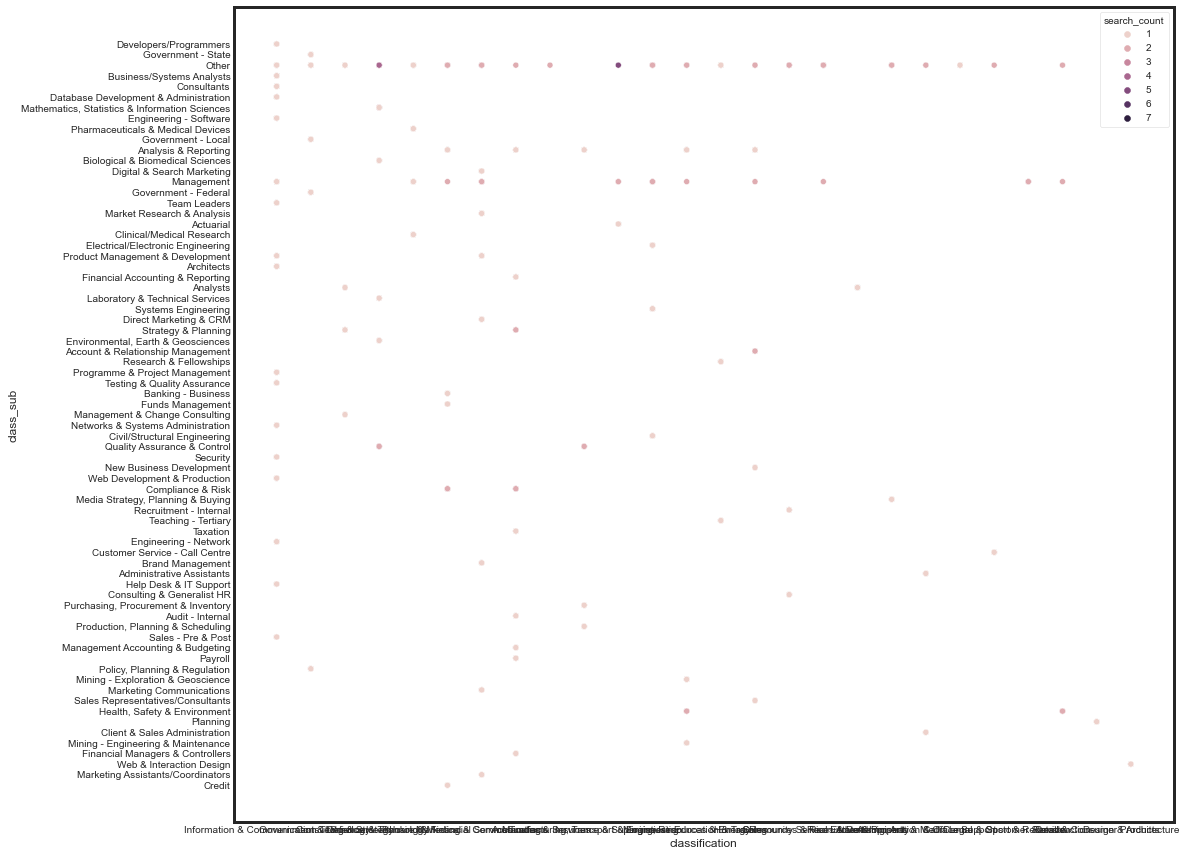

In [88]:
# is there any pattern in the classification and sub-class groupings for the number of searches?
eda_df = joblist_df.loc[:, ('classification', 'class_sub', 'search_count')]

with sns.axes_style('ticks'):
    plt.figure(figsize=(15, 15))
    sns.scatterplot(x=eda_df.classification, y=eda_df.class_sub, hue=eda_df.search_count)
    plt.show()

## no obvious patterns here

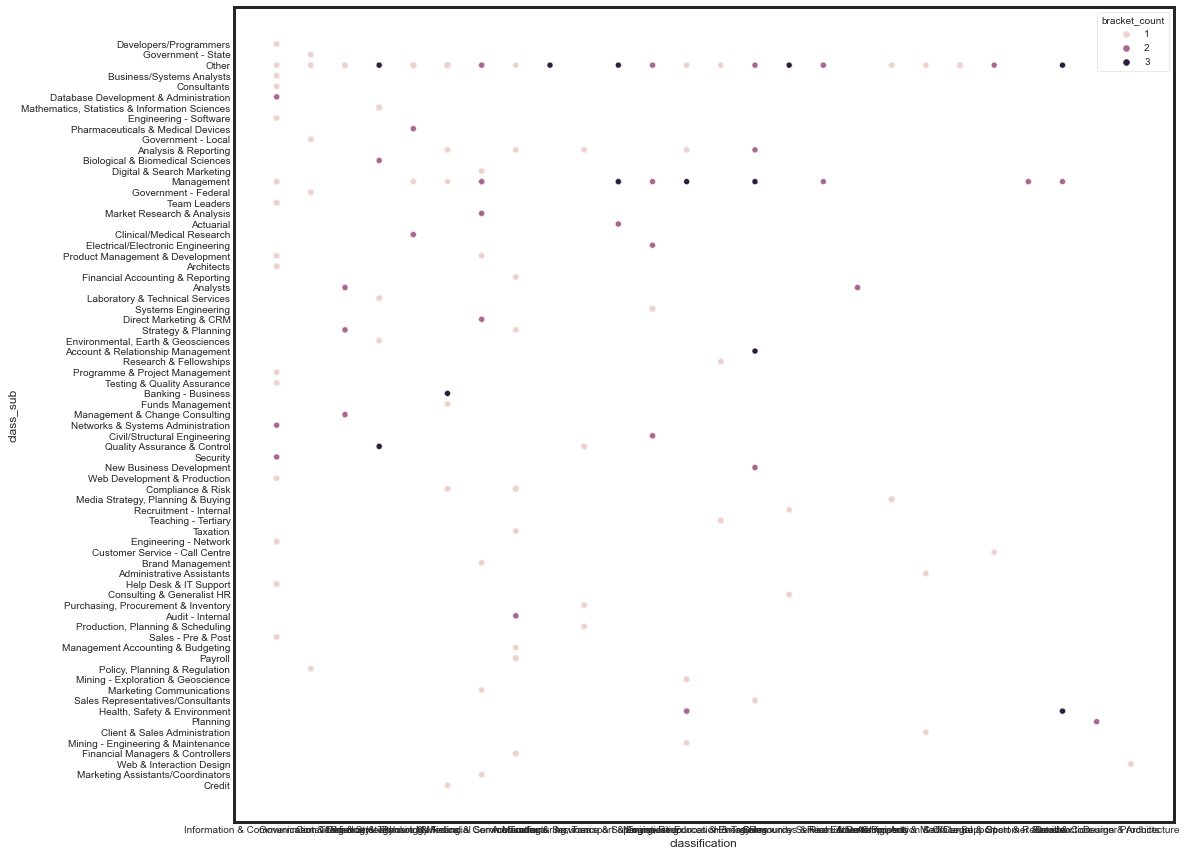

In [89]:
# is there any pattern in the classification and sub-class groupings for the number of salary ranges?
eda_df = joblist_df.loc[:, ('classification', 'class_sub', 'bracket_count')]

with sns.axes_style('ticks'):
    plt.figure(figsize=(15, 15))
    sns.scatterplot(x=eda_df.classification, y=eda_df.class_sub, hue=eda_df.bracket_count)
    plt.show()

## no obvious patterns here

In [90]:
# dummy to get the initial dataframe
eda_dummies = pd.get_dummies(eda_df)
print(eda_dummies.shape)
# eda_dummies.columns

(12109, 98)


<AxesSubplot:>

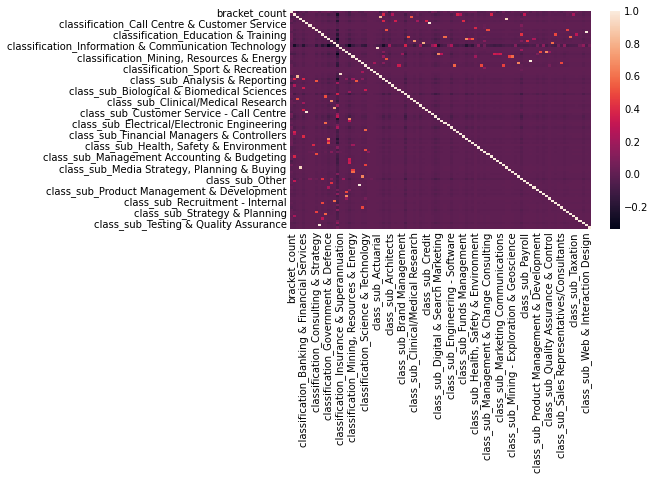

In [91]:
eda_corr = eda_dummies.corr()
sns.heatmap(eda_corr)

## some sprinkles of colour, but too small to identify any obvious trends

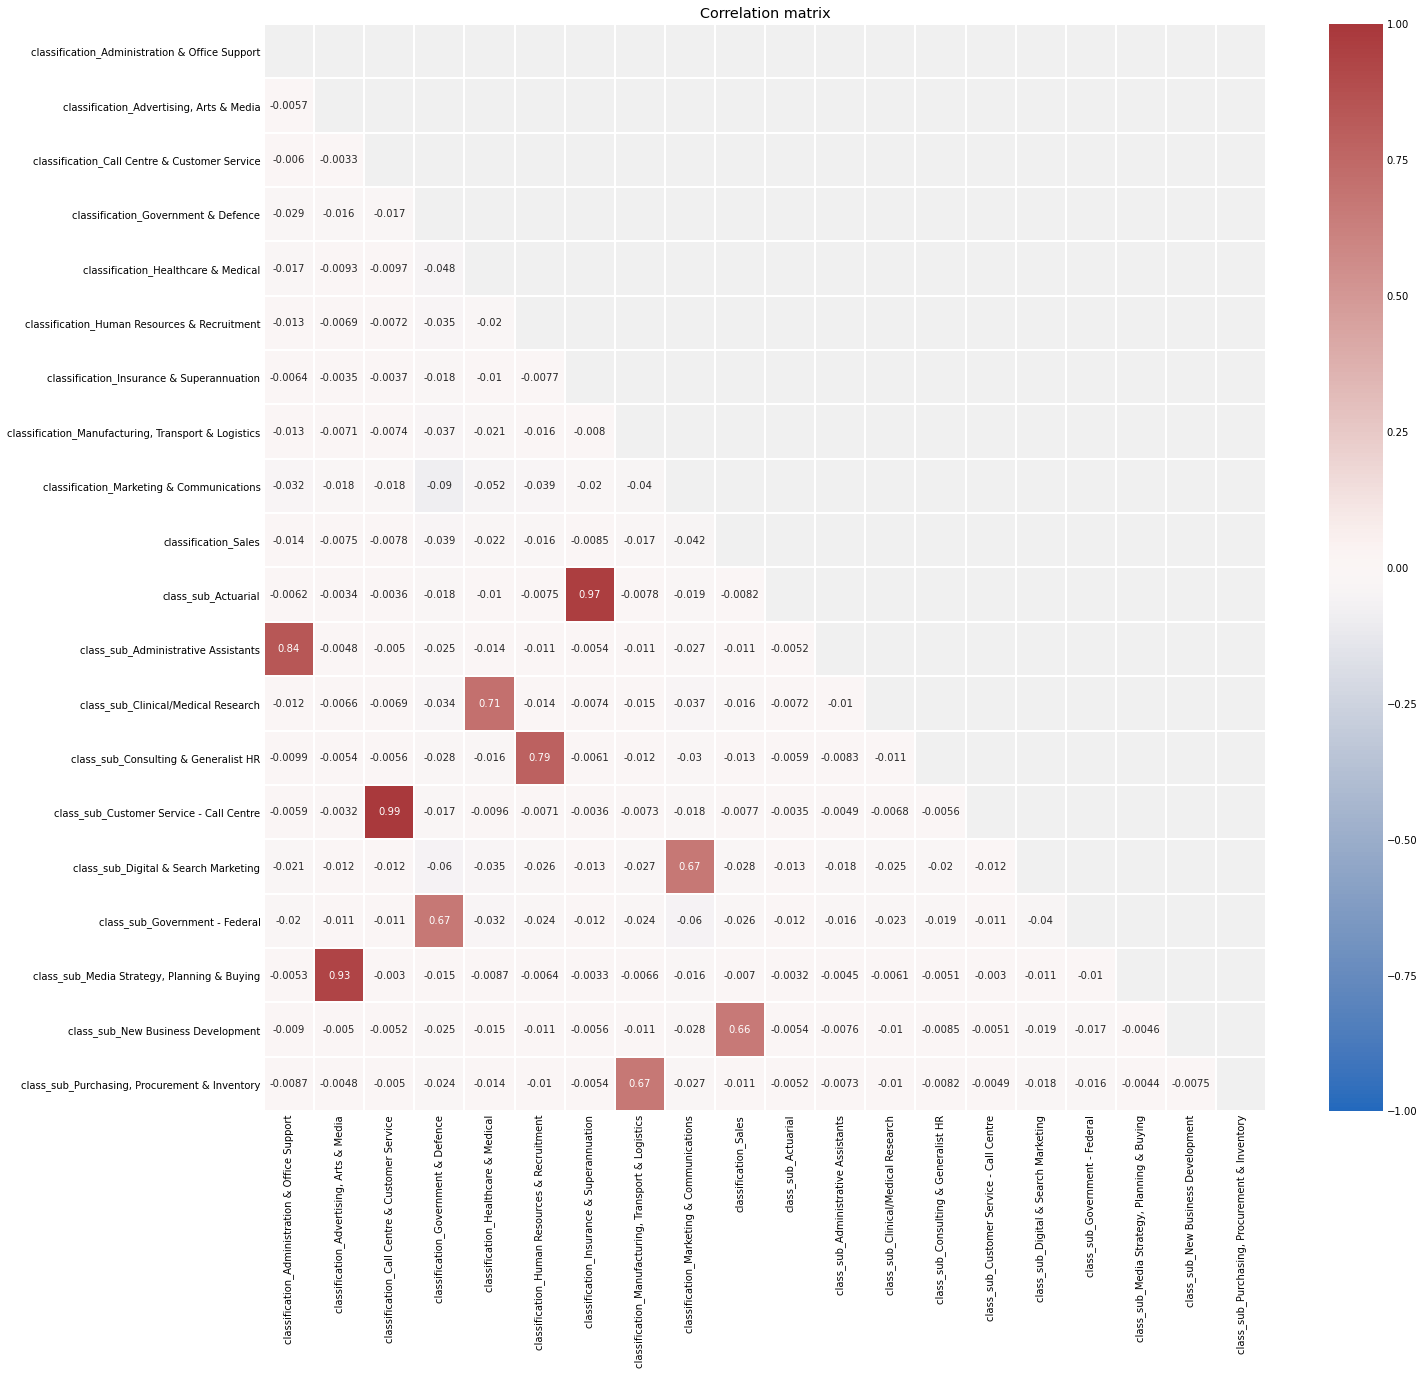

In [92]:
# large plot, show high correlations only
high_corr = (eda_corr.abs() > 0.6) & (eda_corr.abs() <1)
df = list(eda_corr[high_corr.any()].any(axis=1).index)
# df_corr.loc[df,df]

plot_corr(eda_corr.loc[df,df], 20,20)

## obvious correlations, nothing noteworthy

### Look at hierarchial clustering

In [93]:
eda_df = joblist_df.loc[:, ('classification', 'class_sub')]
print(eda_df.shape)
eda_df.head()

(12109, 2)


,classification,class_sub
0,Information & Communication Technology,Developers/Programmers
1,Government & Defence,Government - State
2,Information & Communication Technology,Other
3,Information & Communication Technology,Business/Systems Analysts
4,Information & Communication Technology,Consultants


In [94]:
# dummy to get the initial dataframe
eda_dummies = pd.get_dummies(eda_df)
print(eda_dummies.shape)
# eda_dummies.columns

(12109, 97)


In [95]:
# convert to matrix
eda_matrix = eda_dummies.values

In [96]:
Z = linkage(eda_matrix, 'ward')

In [97]:
Z[-5:]

array([[24104.        , 24209.        ,    42.45808779,  4596.        ],
       [24203.        , 24211.        ,    46.63226853,  4937.        ],
       [23953.        , 24212.        ,    50.2544784 ,  6096.        ],
       [24202.        , 24213.        ,    50.3447804 ,  6013.        ],
       [24214.        , 24215.        ,    83.19536783, 12109.        ]])

In [98]:
c, coph_dists = cophenet(Z, pdist(eda_matrix))

In [99]:
c

0.6650752102583735

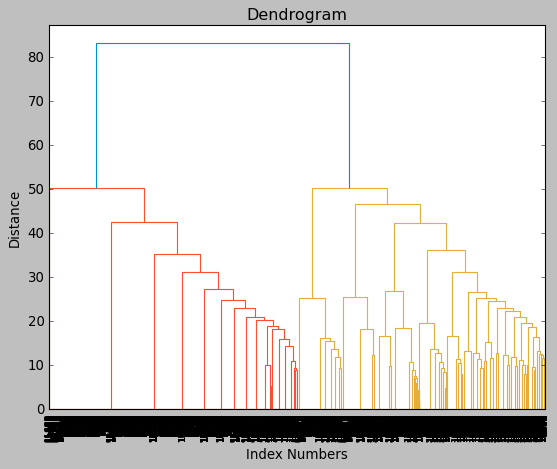

In [100]:
#plot it!
with plt.style.context('classic'): 
    plt.title('Dendrogram')
    plt.xlabel('Index Numbers')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  
        leaf_font_size=8.,
    )
plt.show()

# two pretty distinct groups ... now to find out what in each group

In [101]:
# hierarchical clustering for 2 clusters:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(eda_dummies)

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [102]:
eda_dummies.shape, cluster.labels_.shape

((12109, 97), (12109,))

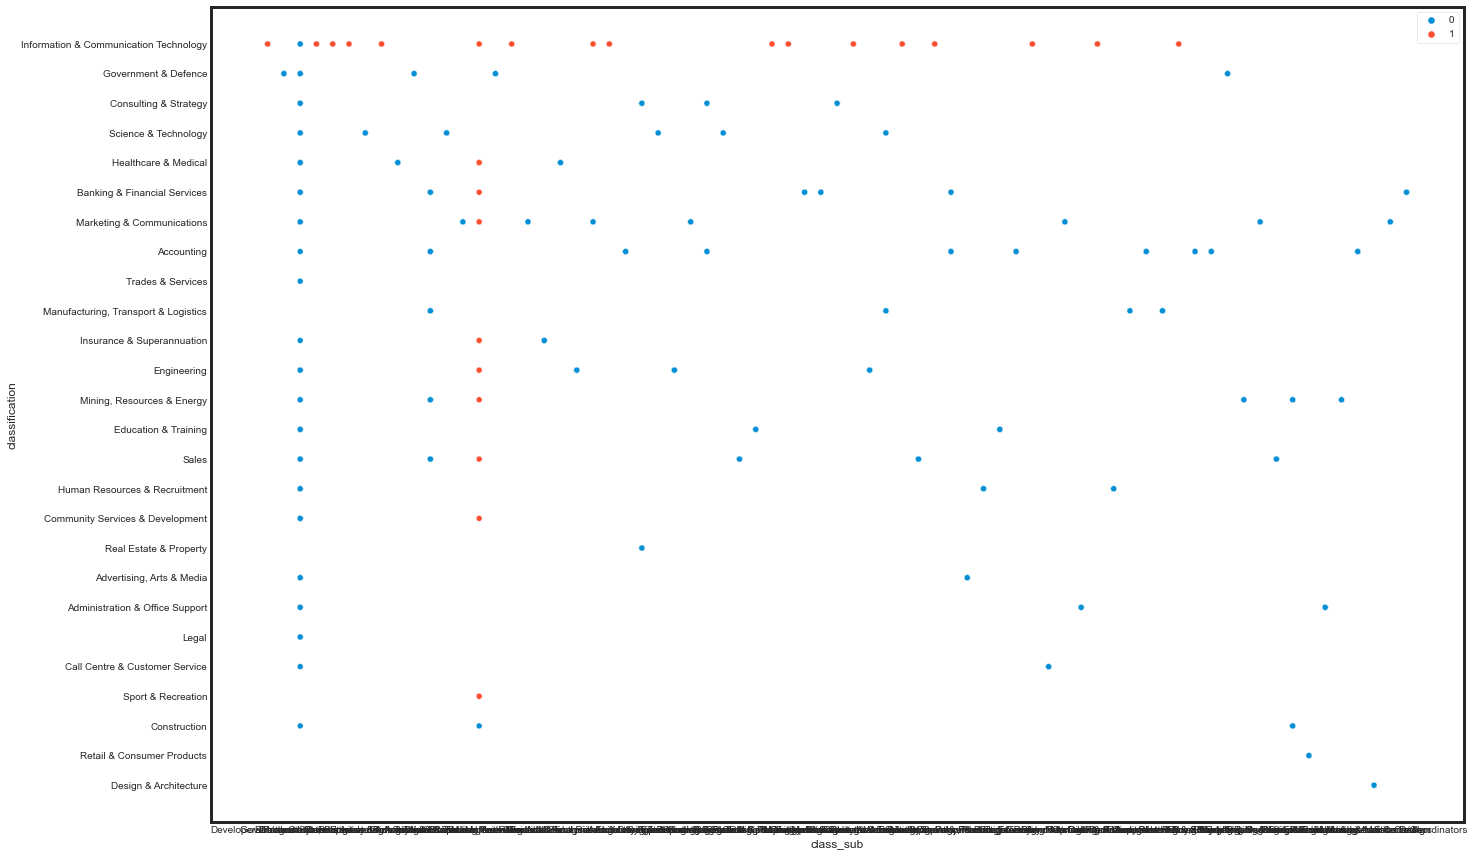

In [103]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(20, 15))  
    sns.scatterplot(y=eda_df.classification, x=eda_df.class_sub, hue=cluster.labels_) 
    plt.show()

# again visually distinct groups

In [104]:
groups = pd.DataFrame(cluster.labels_)
groups.value_counts()

# groups are surprisingly balanced

1    6096
0    6013
dtype: int64

In [105]:
# group 1
eda_df.loc[groups[groups[0] == 1].index].value_counts()

## majority classification = ICT
## expected that this should account for a significant amount of the jobs
## interesting that all other classifications have sub-class = 'Management'

classification                          class_sub                            
Information & Communication Technology  Business/Systems Analysts                1500
                                        Developers/Programmers                   1057
                                        Engineering - Software                    695
                                        Architects                                537
                                        Consultants                               402
                                        Database Development & Administration     331
                                        Testing & Quality Assurance               287
                                        Programme & Project Management            233
                                        Security                                  222
                                        Help Desk & IT Support                    190
                                        Networks & Systems Adm

In [106]:
# group 0 - what are the top 5 class/sub-class
eda_df.loc[groups[groups[0] == 0].index].value_counts().head()


classification                          class_sub                 
Marketing & Communications              Digital & Search Marketing    510
Government & Defence                    Government - Federal          430
Information & Communication Technology  Other                         346
Government & Defence                    Government - State            278
Accounting                              Analysis & Reporting          277
dtype: int64

In [107]:
# look at parts of group 0
eda_df.loc[groups[groups[0] == 0].index, 'classification'].value_counts()

## interesting, but doesn't appear to be useful at the moment

Marketing & Communications                1082
Government & Defence                       925
Accounting                                 671
Banking & Financial Services               437
Education & Training                       385
Information & Communication Technology     346
Healthcare & Medical                       295
Science & Technology                       285
Consulting & Strategy                      271
Sales                                      213
Manufacturing, Transport & Logistics       192
Mining, Resources & Energy                 181
Human Resources & Recruitment              180
Engineering                                136
Administration & Office Support            125
Insurance & Superannuation                  46
Real Estate & Property                      42
Design & Architecture                       41
Call Centre & Customer Service              41
Advertising, Arts & Media                   38
Retail & Consumer Products                  34
Legal        

In [108]:
# look at parts of group 0
eda_df.loc[groups[groups[0] == 0].index, 'class_sub'].value_counts()

## interesting, but doesn't appear to be useful at the moment

Other                                             858
Analysis & Reporting                              668
Digital & Search Marketing                        510
Government - Federal                              430
Government - State                                278
Clinical/Medical Research                         165
Analysts                                          148
Market Research & Analysis                        139
Marketing Communications                          138
Government - Local                                117
Consulting & Generalist HR                        112
Marketing Assistants/Coordinators                 107
Management Accounting & Budgeting                 101
Financial Accounting & Reporting                   95
New Business Development                           94
Research & Fellowships                             94
Environmental, Earth & Geosciences                 92
Direct Marketing & CRM                             92
Administrative Assistants   

### LDA : Classification

in Workbook2

I separated out this LDA section because it was causing depreciation warnings throughout the workbook & I didn't want it to re-run the visualisation everytime I restarted & reran this workbook.

<div>
<img src="images/LDA-classification-visual.png" width="700"/>
</div>
<br> 

---
[back to index](#index)
<a id='location'></a>
## EDA: location, loc_area, company
<br>


number of nulls: 0
number of unique values: 61


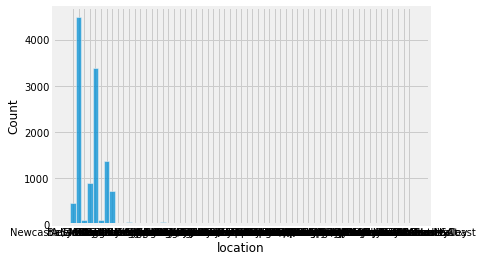

In [109]:
# LOCATION

print('number of nulls:', joblist_df.location.isna().sum())
print('number of unique values:', len(joblist_df.location.unique()))
sns.histplot(joblist_df.location);

## no nulls - could be used in models
## high count grouping as expected for capital & major cities
## potentially group into: inner city, suburban, regional, other

number of nulls: 4094
number of unique values: 23


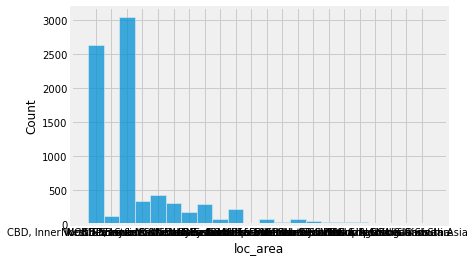

In [110]:
# LOC_AREA : subgroups of location

print('number of nulls:', joblist_df.loc_area.isna().sum())
print('number of unique values:', len(joblist_df.loc_area.unique()))
sns.histplot(joblist_df[~joblist_df.loc_area.isna()]['loc_area']);

## lots of nulls, ~1/3 are null - unlikely to be useful
## high count grouping for areas within captial & major cities - unlikely to add anything that location won't already
## potentially use to create location brackets: inner city, suburban, regional, other
## >> ignore for now

In [111]:
# show count of location/loc_area
joblist_df.groupby(['location','loc_area']).count()['job_id']  #.sort_values(ascending=False)

## didn't expect to see Americas / Asia Pacific in locations

location      loc_area                           
Americas      USA & Canada                              1
Asia Pacific  India & South Asia                        1
              PNG & Pacific Islands                     2
Brisbane      Bayside & Eastern Suburbs                 8
              CBD & Inner Suburbs                     876
              Northern Suburbs                         37
              Southern Suburbs & Logan                 40
              Western Suburbs & Ipswich                27
Melbourne     Bayside & South Eastern Suburbs         180
              CBD & Inner Suburbs                    2171
              Eastern Suburbs                         261
              Northern Suburbs                         80
              Western Suburbs                          71
Perth         CBD, Inner & Western Suburbs            428
              Eastern Suburbs                          39
              Fremantle & Southern Suburbs             83
              Northern

In [112]:
# show count of loc_area/location
# sometimes looking at the grouping the other way around highlights connections otherwise missed
joblist_df.groupby(['loc_area', 'location']).count()['job_id']  #.sort_values(ascending=False)

## cities don't describe their suburb grouping in the same way, even for CBD/Inner city

loc_area                             location    
Bayside & Eastern Suburbs            Brisbane           8
Bayside & South Eastern Suburbs      Melbourne        180
CBD & Inner Suburbs                  Brisbane         876
                                     Melbourne       2171
CBD, Inner & Western Suburbs         Perth            428
CBD, Inner West & Eastern Suburbs    Sydney          2634
Eastern Suburbs                      Melbourne        261
                                     Perth             39
Fremantle & Southern Suburbs         Perth             83
India & South Asia                   Asia Pacific       1
North Shore & Northern Beaches       Sydney           336
North West & Hills District          Sydney            78
Northern Suburbs                     Brisbane          37
                                     Melbourne         80
Northern Suburbs & Joondalup         Perth             40
PNG & Pacific Islands                Asia Pacific       2
Parramatta & Western S

### Company

In [113]:
# how many companies are advertising?
print('number of nulls:', jobdetail_df.company.isna().sum())
print('number of unique values:', len(jobdetail_df.company.unique()))
company_count = jobdetail_df.company.value_counts()
company_count.head()

## looks to be a required field - no nulls

number of nulls: 0
number of unique values: 3573


Talent – SEEK Recruitment Agency of the Year | 7 Time Winner    140
Private Advertiser                                              133
Bluefin Resources Pty Limited                                   110
Datacom                                                         105
Paxus                                                            98
Name: company, dtype: int64

In [114]:
# how many companies are advertising multiple times?
print('Total number of companies:', len(jobdetail_df.company.unique()))
print('Companies with over 3 job adverts:', len(jobdetail_df[jobdetail_df.company.isin(
    company_count[company_count.values > 3].index.tolist())]['company'].unique()))
print('Companies with 3 or less job adverts:', len(jobdetail_df[jobdetail_df.company.isin(
    company_count[company_count.values <= 3].index.tolist())]['company'].unique()))

## ~20% of companies are responsible for the majority of job advertisements
## For this analysis this skew means company isn't a priority to put to estimator models.
## potential for future analysis: What do the top recruiters put in their adverts?

Total number of companies: 3573
Companies with over 3 job adverts: 694
Companies with 3 or less job adverts: 2879


---
[back to index](#index)
<a id='title'></a>
## EDA Job Title


In [115]:
df_title = joblist_df.loc[:,'title']
print(df_title.shape)
df_title.value_counts().head(20)

## lots of individualised job titles

(12109,)


Business Analyst                258
Senior Business Analyst         115
Solution Architect               94
Data Engineer                    91
Data Analyst                     79
Technical Business Analyst       73
DevOps Engineer                  61
Software Engineer                46
Senior Data Engineer             45
Commercial Analyst               44
Digital Marketing Specialist     44
Test Analyst                     42
Senior Software Engineer         41
Financial Analyst                38
Senior Test Analyst              35
Data Scientist                   31
Digital Marketing Manager        30
Marketing Coordinator            30
Solutions Architect              27
Product Manager                  26
Name: title, dtype: int64

In [116]:
'''tokenize job title - what are words are commonly used?
comment out each parameter option after I've tried it
'''
# vect = CountVectorizer(lowercase=True, ngram_range=(1,1))     # parameters 1
# vect = CountVectorizer(lowercase=True, ngram_range=(1,1), min_df=5)    # parameters 2
vect = CountVectorizer(lowercase=True, ngram_range=(1,2), min_df=5)   # parameters 3
wf = vect.fit_transform(df_title)
wf

<12109x1884 sparse matrix of type '<class 'numpy.int64'>'
	with 58317 stored elements in Compressed Sparse Row format>

In [117]:
# count the number of times each word was used across all job titles
count_list = wf.toarray().sum(axis=0)
word_list = vect.get_feature_names()

# create dataframe to see word & count
wf_title = pd.DataFrame()
wf_title = pd.DataFrame([word_list,count_list]).T
wf_title.rename(columns={0:'title_word', 1:'count'}, inplace=True)

In [118]:
print(wf_title.shape)
wf_title
## lots of numbers but low frequency - try removing numbers & changing the parameters
## parameters 1 : 2810,2
## parameters 2 : 765,2
## parameters 3 : 1884,2

(1884, 2)


,title_word,count
0,000,11
1,10,7
2,110k,5
3,110k super,5
4,12,82
5,12 month,54
6,12 months,16
7,12 mth,10
8,12m,5
9,12m contract,5


In [119]:
# what are all the numbers in the title_words?
title_numbers = list()
for val in wf_title.title_word.values:
    num = re.findall(r'\w*\d+?\w+(?:\s+\d+?\w+)*\s*',val)
    if num != []:
        title_numbers.append(num)

print(len(title_numbers))
# title_numbers

31


In [120]:
# change into list
title_ignore = list()
title_ignore = [','.join(map(str, l)) for l in title_numbers]
# title_ignore

In [121]:
# create custom stopwords list - add other words to ignore in the title
title_ignore += ['month', 'months', 'super', 'year', 'years', 'the', 'in', 'it']
title_ignore = set(title_ignore)
# title_ignore

In [122]:
# save stopword custom list
np.savetxt("./datasets/stopwords_title.csv", 
           list(title_ignore),
           delimiter =", ", fmt ='% s')

In [123]:
joblist_df[joblist_df['title'].str.contains('182195')]

## same job but company have listed it twice to get more coverage of potential applicants
## separate listings on seek - leave in

,job_id,title,location,loc_area,classification,class_sub,desc_short,salary,bracket_count,salary_0-80k,salary_80-100k,salary_100-120k,salary_120k_plus,search_AI,search_BI,search_DArch,search_DE,search_ML,search_DA,search_DS,search_count
6694,52527832,"Principal Policy Analyst, Clerk Grade 11/12 - ...",Sydney,Parramatta & Western Suburbs,Government & Defence,Government - State,The Principal Policy Analyst leads and manages...,NaN,1,0,0,0,1,0,0,0,0,0,1,0,1
6695,52527831,"Principal Policy Analyst, Clerk Grade 11/12 - ...",Sydney,Parramatta & Western Suburbs,Government & Defence,"Policy, Planning & Regulation",The Principal Policy Analyst leads and manages...,NaN,1,0,0,0,1,0,0,0,0,0,1,0,1


In [124]:
# top words in job titles
wf_title.sort_values('count', ascending=False)[:20]

## I'm not surprised that 'and' is rating so highly, it will be in jobs which combine multiple roles
## leave it in so models can evaluate it's usefulness

,title_word,count
78,analyst,3428
1539,senior,2029
336,business,1748
520,data,1299
691,engineer,1291
1074,manager,1165
339,business analyst,1120
579,developer,855
1670,specialist,719
151,and,674


In [125]:
# lots of occasional words
wf_title.sort_values('count', ascending=True)[:20]

## change parameters to ignore anything with a count under 5

,title_word,count
1883,your,5
700,engineer java,5
294,aws remote,5
293,aws engineer,5
701,engineer project,5
703,engineer senior,5
705,engineer test,5
1685,sre,5
287,autonomous mining,5
710,engineers multiple,5


### good parameters

In [126]:
# now the custom stopwords list has been created, re-run the good parameters
# parameters 3: ngram + min_df + stop_words + max features  
vect = CountVectorizer(lowercase=True, ngram_range=(1,2), min_df=5, 
                       stop_words=title_ignore, max_features=300)
wf = vect.fit_transform(df_title)

In [127]:
# create document term matrix
dtm = wf.toarray()
dtm.shape

(12109, 300)

In [128]:
# count the number of times each word was used across all job titles
count_list = wf.toarray().sum(axis=0)
word_list = vect.get_feature_names()

# create dataframe to see word & count
wf_title = pd.DataFrame()
wf_title = pd.DataFrame([word_list,count_list]).T
wf_title.rename(columns={0:'title_word', 1:'count'}, inplace=True)

In [129]:
print(wf_title.shape)
wf_title.sort_values(by='count', ascending=False)
# (1884, 2)

(300, 2)


,title_word,count
9,analyst,3428
244,senior,2029
37,business,1748
70,data,1299
99,engineer,1291
157,manager,1165
38,business analyst,1121
82,developer,855
266,specialist,719
14,and,674


---
[back to index](#index)
<a id='q1'></a>
## Q1: Job Salary Factors
<br>
Features in predictor matrix:  

- title (tokenized)
- class (dummied)
- class_sub (dummied)
- employ_type (dummied)
<br>

Target:
- salary brackets (as class labels)

<a id='4_salary_brackets'></a>
## 4 salary brackets
### Prepare predictor dataset

In [130]:
# reminder of columns in datasets
print(jobdetail_df.columns)
joblist_df.columns

Index(['job_id', 'title', 'company', 'salary', 'employ_type', 'desc_full'], dtype='object')


Index(['job_id', 'title', 'location', 'loc_area', 'classification',
       'class_sub', 'desc_short', 'salary', 'bracket_count', 'salary_0-80k',
       'salary_80-100k', 'salary_100-120k', 'salary_120k_plus', 'search_AI',
       'search_BI', 'search_DArch', 'search_DE', 'search_ML', 'search_DA',
       'search_DS', 'search_count'],
      dtype='object')

In [131]:
# choose only jobs which appeared in only one salary range
df = joblist_df[joblist_df.bracket_count == 1]
df.shape

## 5787 jobs in only one bracket

(5787, 21)

In [132]:
# assign salary ranges to target
y_df = df[['job_id', 'salary_0-80k', 'salary_80-100k', 'salary_100-120k', 'salary_120k_plus']]

# subset predictors to only needed features
df = df[['job_id', 'title', 'classification', 'class_sub']]
df.rename(columns={'classification':'class'}, inplace=True)
print(df.shape, y_df.shape)
df.head(2)

(5787, 4) (5787, 5)


,job_id,title,class,class_sub
2,52609378,Data Scientist,Information & Communication Technology,Other
4,52609686,Graduate Data Consultants,Information & Communication Technology,Consultants


In [133]:
# add employ_type from jobdetail
df = df.merge(jobdetail_df[['job_id', 'employ_type']], how='left', on='job_id')
print(df.shape)
df.head(2)

(5787, 5)


,job_id,title,class,class_sub,employ_type
0,52609378,Data Scientist,Information & Communication Technology,Other,Contract/Temp
1,52609686,Graduate Data Consultants,Information & Communication Technology,Consultants,Full Time


### Strip special characters from class, class_sub

In [134]:
# I'm sure there's a more efficient way - but this works
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]

for char in spec_chars:
    df['class'] = df['class'].str.replace(char,'', regex=False)
    df['class_sub'] = df['class_sub'].str.replace(char,'', regex=False)

# get rid of excess whitespaces
df['class'] = df['class'].str.split().str.join(" ")
df['class_sub'] = df['class_sub'].str.split().str.join(" ")    

df.head(2)

,job_id,title,class,class_sub,employ_type
0,52609378,Data Scientist,Information Communication Technology,Other,Contract/Temp
1,52609686,Graduate Data Consultants,Information Communication Technology,Consultants,Full Time


### Prepare target

In [135]:
# prepare target
print(y_df.shape)
# y_df.reset_index(drop=True, inplace=True)
y_df.head(2)

(5787, 5)


,job_id,salary_0-80k,salary_80-100k,salary_100-120k,salary_120k_plus
2,52609378,1,0,0,0
4,52609686,1,0,0,0


In [136]:
# create salary target groups
salary_group = list()
for i in y_df.index:
    if y_df.loc[i,'salary_0-80k'] == 1:
        salary_group.append(1)
    elif y_df.loc[i,'salary_80-100k'] == 1:
        salary_group.append(2)
    elif y_df.loc[i,'salary_100-120k'] == 1:
        salary_group.append(3)
    elif y_df.loc[i,'salary_120k_plus'] == 1:
        salary_group.append(4)
    else:
        salary_group.append(0)

len(salary_group)

5787

In [137]:
y_df['salary_group'] = salary_group
print(y_df.shape)
y_df.head(2)

(5787, 6)


,job_id,salary_0-80k,salary_80-100k,salary_100-120k,salary_120k_plus,salary_group
2,52609378,1,0,0,0,1
4,52609686,1,0,0,0,1


In [138]:
# check baseline & balance of classes
y_df.salary_group.value_counts(normalize=True)

## unbalanced, but lets see what the models predict

4    0.423881
1    0.336444
3    0.120270
2    0.119406
Name: salary_group, dtype: float64

In [139]:
# check size & features of predictor and target dataframes
print(df.shape, y_df.shape)
df.columns, y_df.columns

(5787, 5) (5787, 6)


(Index(['job_id', 'title', 'class', 'class_sub', 'employ_type'], dtype='object'),
 Index(['job_id', 'salary_0-80k', 'salary_80-100k', 'salary_100-120k',
        'salary_120k_plus', 'salary_group'],
       dtype='object'))

### Allocate X/y & train-test split

In [140]:
# allocate X/y
X_df = df[['job_id','title', 'class', 'class_sub', 'employ_type']]
y = pd.Series(y_df['salary_group'])
X_df.shape, y.shape

((5787, 5), (5787,))

In [141]:
# train-test split
X1_tr_df, X1_te_df, y1_tr, y1_te = train_test_split(X_df, y, test_size=0.33, 
                                                stratify=y, random_state=42)
print(X1_tr_df.shape, y1_tr.shape)
print(X1_te_df.shape, y1_te.shape)
X1_tr_df.head(2)

(3877, 5) (3877,)
(1910, 5) (1910,)


,job_id,title,class,class_sub,employ_type
4589,52561725,HR Advisor Occupational Health & Safety,Government Defence,Government State,Full Time
2976,52398926,Business Development Adviser,Marketing Communications,Marketing Communications,Full Time


### Dummy columns in train & test - then align test to train

In [142]:
# dummy for X train
df_dummies = pd.get_dummies(data=X1_tr_df, columns=['class', 'class_sub', 'employ_type'])
df_dummies.drop(columns=['job_id','title'], inplace=True)
print(df_dummies.shape)
df_dummies.head(2)

(3877, 95)


,class_Accounting,class_Administration Office Support,class_Advertising Arts Media,class_Banking Financial Services,class_Call Centre Customer Service,class_Community Services Development,class_Consulting Strategy,class_Design Architecture,class_Education Training,class_Engineering,class_Government Defence,class_Healthcare Medical,class_Human Resources Recruitment,class_Information Communication Technology,class_Insurance Superannuation,class_Legal,class_Manufacturing Transport Logistics,class_Marketing Communications,class_Mining Resources Energy,class_Real Estate Property,class_Retail Consumer Products,class_Sales,class_Science Technology,class_sub_Account Relationship Management,class_sub_Actuarial,class_sub_Administrative Assistants,class_sub_Analysis Reporting,class_sub_Analysts,class_sub_Architects,class_sub_Audit Internal,class_sub_Banking Business,class_sub_Biological Biomedical Sciences,class_sub_Brand Management,class_sub_BusinessSystems Analysts,class_sub_CivilStructural Engineering,class_sub_Client Sales Administration,class_sub_ClinicalMedical Research,class_sub_Compliance Risk,class_sub_Consultants,class_sub_Consulting Generalist HR,class_sub_Credit,class_sub_Customer Service Call Centre,class_sub_Database Development Administration,class_sub_DevelopersProgrammers,class_sub_Digital Search Marketing,class_sub_Direct Marketing CRM,class_sub_ElectricalElectronic Engineering,class_sub_Engineering Network,class_sub_Engineering Software,class_sub_Environmental Earth Geosciences,class_sub_Financial Accounting Reporting,class_sub_Financial Managers Controllers,class_sub_Funds Management,class_sub_Government Federal,class_sub_Government Local,class_sub_Government State,class_sub_Help Desk IT Support,class_sub_Laboratory Technical Services,class_sub_Management,class_sub_Management Accounting Budgeting,class_sub_Management Change Consulting,class_sub_Market Research Analysis,class_sub_Marketing AssistantsCoordinators,class_sub_Marketing Communications,class_sub_Mathematics Statistics Information Sciences,class_sub_Media Strategy Planning Buying,class_sub_Mining Engineering Maintenance,class_sub_Mining Exploration Geoscience,class_sub_Networks Systems Administration,class_sub_New Business Development,class_sub_Other,class_sub_Payroll,class_sub_Pharmaceuticals Medical Devices,class_sub_Planning,class_sub_Policy Planning Regulation,class_sub_Product Management Development,class_sub_Production Planning Scheduling,class_sub_Programme Project Management,class_sub_Purchasing Procurement Inventory,class_sub_Quality Assurance Control,class_sub_Recruitment Internal,class_sub_Research Fellowships,class_sub_Sales Pre Post,class_sub_Sales RepresentativesConsultants,class_sub_Security,class_sub_Strategy Planning,class_sub_Systems Engineering,class_sub_Taxation,class_sub_Teaching Tertiary,class_sub_Team Leaders,class_sub_Testing Quality Assurance,class_sub_Web Development Production,class_sub_Web Interaction Design,employ_type_Contract/Temp,employ_type_Full Time
4589,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [143]:
# dummy for X test
df_te_dummies = pd.get_dummies(data=X1_te_df, columns=['class', 'class_sub', 'employ_type'])
df_te_dummies.drop(columns=['job_id','title'], inplace=True)
print(df_te_dummies.shape)
df_te_dummies.head(2)

(1910, 95)


,class_Accounting,class_Administration Office Support,class_Advertising Arts Media,class_Banking Financial Services,class_Call Centre Customer Service,class_Community Services Development,class_Consulting Strategy,class_Design Architecture,class_Education Training,class_Engineering,class_Government Defence,class_Healthcare Medical,class_Human Resources Recruitment,class_Information Communication Technology,class_Insurance Superannuation,class_Legal,class_Manufacturing Transport Logistics,class_Marketing Communications,class_Mining Resources Energy,class_Real Estate Property,class_Retail Consumer Products,class_Sales,class_Science Technology,class_sub_Actuarial,class_sub_Administrative Assistants,class_sub_Analysis Reporting,class_sub_Analysts,class_sub_Architects,class_sub_Audit Internal,class_sub_Banking Business,class_sub_Biological Biomedical Sciences,class_sub_Brand Management,class_sub_BusinessSystems Analysts,class_sub_CivilStructural Engineering,class_sub_Client Sales Administration,class_sub_ClinicalMedical Research,class_sub_Compliance Risk,class_sub_Consultants,class_sub_Consulting Generalist HR,class_sub_Credit,class_sub_Customer Service Call Centre,class_sub_Database Development Administration,class_sub_DevelopersProgrammers,class_sub_Digital Search Marketing,class_sub_Direct Marketing CRM,class_sub_ElectricalElectronic Engineering,class_sub_Engineering Network,class_sub_Engineering Software,class_sub_Environmental Earth Geosciences,class_sub_Financial Accounting Reporting,class_sub_Financial Managers Controllers,class_sub_Funds Management,class_sub_Government Federal,class_sub_Government Local,class_sub_Government State,class_sub_Health Safety Environment,class_sub_Help Desk IT Support,class_sub_Laboratory Technical Services,class_sub_Management,class_sub_Management Accounting Budgeting,class_sub_Management Change Consulting,class_sub_Market Research Analysis,class_sub_Marketing AssistantsCoordinators,class_sub_Marketing Communications,class_sub_Mathematics Statistics Information Sciences,class_sub_Media Strategy Planning Buying,class_sub_Mining Engineering Maintenance,class_sub_Mining Exploration Geoscience,class_sub_Networks Systems Administration,class_sub_New Business Development,class_sub_Other,class_sub_Payroll,class_sub_Pharmaceuticals Medical Devices,class_sub_Planning,class_sub_Policy Planning Regulation,class_sub_Product Management Development,class_sub_Production Planning Scheduling,class_sub_Programme Project Management,class_sub_Purchasing Procurement Inventory,class_sub_Quality Assurance Control,class_sub_Recruitment Internal,class_sub_Research Fellowships,class_sub_Sales Pre Post,class_sub_Sales RepresentativesConsultants,class_sub_Security,class_sub_Strategy Planning,class_sub_Systems Engineering,class_sub_Taxation,class_sub_Teaching Tertiary,class_sub_Team Leaders,class_sub_Testing Quality Assurance,class_sub_Web Development Production,class_sub_Web Interaction Design,employ_type_Contract/Temp,employ_type_Full Time
624,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
358,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [144]:
# looks like the same dummies in test & train, but best to make sure
df_dummies, df_te_dummies = df_dummies.align(df_te_dummies, join='left', axis=1)

# fill any nans with 0
df_te_dummies.fillna(value=0, inplace=True)
print(df_dummies.shape, df_te_dummies.shape)

(3877, 95) (1910, 95)


### Tokenize in train & test, align - then add to dummied columns

In [145]:
# load in custom stopword list for title column
title_ignore = pd.read_csv('./datasets/stopwords_title.csv', header=None)
title_ignore = list(pd.Series(title_ignore[0]))

In [146]:
# check that it imported ok
print(type(title_ignore))
# title_ignore

<class 'list'>


In [147]:
X1_te_df.columns, X1_tr_df.columns

(Index(['job_id', 'title', 'class', 'class_sub', 'employ_type'], dtype='object'),
 Index(['job_id', 'title', 'class', 'class_sub', 'employ_type'], dtype='object'))

In [148]:
# use good parameters
vect = CountVectorizer(lowercase=True, ngram_range=(1,2), min_df=5, 
                       stop_words=title_ignore, max_features=300)

wf = vect.fit_transform(X1_tr_df['title'])
wf_te = vect.transform(X1_te_df['title'])

In [149]:
count_list = wf.toarray().sum(axis=0)
word_list = vect.get_feature_names()

In [150]:
# train
dtm = wf.toarray()
print(dtm.shape)
dtm_df = pd.DataFrame(dtm, columns=word_list)
print(dtm_df.shape)
dtm_df.head(2)

(3877, 300)
(3877, 300)


,account,account manager,accountant,acquisition,administration,administration officer,administrator,advisor,advisory,agile,agile business,analysis,analyst,analyst contract,analyst digital,analyst financial,analysts,analytics,and,application,application support,applications,aps,aps5,aps6,architect,assistant,associate,assurance,audit,australia,australian,automation,aws,azure,ba,banking,based,based darwin,bi,bi developer,brisbane,business,business analysis,business analyst,business analysts,business development,business intelligence,business partner,business systems,campaign,centre,chain,change,client,clinical,clinical research,cloud,cloud engineer,co,commerce,commercial,commercial analyst,communications,compliance,consultant,consultants,content,contract,control,coordinator,credit,credit analyst,crm,customer,customer service,cyber,cyber security,darwin,data,data analyst,data analytics,data engineer,data migration,database,delivery,demand,design,designer,desk,developer,developers,development,development manager,devops,devops engineer,digital,digital marketing,director,division,dynamics,ecommerce,el1,end,end developer,engagement,engineer,engineering,engineers,enterprise,enterprise architect,erp,etl,executive,experience,fellow,finance,financial,financial analyst,fixed,fixed term,for,full,full stack,functional,geologist,global,governance,government,graduate,group,head,head of,health,hr,ict,implementation,implementation consultant,industry,information,information management,information security,infrastructure,insights,integration,intelligence,internal,inventory,investment,java,junior,laboratory,lead,leader,learning,level,management,manager,marketing,marketing and,marketing coordinator,marketing manager,marketing specialist,master,mdm,media,melbourne,microsoft,mid,migration,multiple,national,net,network,of,office,officer,officers,operations,operations analyst,opportunities,or,oracle,owner,partner,payroll,performance,phd,phd scholarship,planner,planning,platform,policy,portfolio,positions,power,power bi,pricing,principal,process,procurement,product,product manager,product owner,production,professor,program,programmer,project,project manager,project officer,projects,property,python,python developer,quality,regulatory,remote,reporting,reporting analyst,representative,research,research assistant,research fellow,retail,risk,roles,saas,sales,salesforce,sap,scholarship,scientist,security,security analyst,security engineer,senior,senior analyst,senior business,senior consultant,senior data,senior devops,senior full,senior manager,senior project,senior software,senior solution,senior test,seo,service,service desk,services,sharepoint,social,social media,software,software developer,software engineer,solution,solution architect,solution designer,solutions,solutions architect,specialist,sql,stack,stack developer,start,strategy,supply,supply chain,support,support analyst,support engineer,support officer,sydney,system,systems,systems analyst,systems engineer,talent,talent acquisition,team,tech,tech lead,technical,technical business,technical lead,technician,technology,term,test,test analyst,tester,to,transformation,ui,ux,website,workforce
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [151]:
# test
dtm_te = wf_te.toarray()
print(dtm_te.shape)
dtm_te_df = pd.DataFrame(dtm_te, columns=word_list)
print(dtm_te_df.shape)
dtm_te_df.head(2)

(1910, 300)
(1910, 300)


,account,account manager,accountant,acquisition,administration,administration officer,administrator,advisor,advisory,agile,agile business,analysis,analyst,analyst contract,analyst digital,analyst financial,analysts,analytics,and,application,application support,applications,aps,aps5,aps6,architect,assistant,associate,assurance,audit,australia,australian,automation,aws,azure,ba,banking,based,based darwin,bi,bi developer,brisbane,business,business analysis,business analyst,business analysts,business development,business intelligence,business partner,business systems,campaign,centre,chain,change,client,clinical,clinical research,cloud,cloud engineer,co,commerce,commercial,commercial analyst,communications,compliance,consultant,consultants,content,contract,control,coordinator,credit,credit analyst,crm,customer,customer service,cyber,cyber security,darwin,data,data analyst,data analytics,data engineer,data migration,database,delivery,demand,design,designer,desk,developer,developers,development,development manager,devops,devops engineer,digital,digital marketing,director,division,dynamics,ecommerce,el1,end,end developer,engagement,engineer,engineering,engineers,enterprise,enterprise architect,erp,etl,executive,experience,fellow,finance,financial,financial analyst,fixed,fixed term,for,full,full stack,functional,geologist,global,governance,government,graduate,group,head,head of,health,hr,ict,implementation,implementation consultant,industry,information,information management,information security,infrastructure,insights,integration,intelligence,internal,inventory,investment,java,junior,laboratory,lead,leader,learning,level,management,manager,marketing,marketing and,marketing coordinator,marketing manager,marketing specialist,master,mdm,media,melbourne,microsoft,mid,migration,multiple,national,net,network,of,office,officer,officers,operations,operations analyst,opportunities,or,oracle,owner,partner,payroll,performance,phd,phd scholarship,planner,planning,platform,policy,portfolio,positions,power,power bi,pricing,principal,process,procurement,product,product manager,product owner,production,professor,program,programmer,project,project manager,project officer,projects,property,python,python developer,quality,regulatory,remote,reporting,reporting analyst,representative,research,research assistant,research fellow,retail,risk,roles,saas,sales,salesforce,sap,scholarship,scientist,security,security analyst,security engineer,senior,senior analyst,senior business,senior consultant,senior data,senior devops,senior full,senior manager,senior project,senior software,senior solution,senior test,seo,service,service desk,services,sharepoint,social,social media,software,software developer,software engineer,solution,solution architect,solution designer,solutions,solutions architect,specialist,sql,stack,stack developer,start,strategy,supply,supply chain,support,support analyst,support engineer,support officer,sydney,system,systems,systems analyst,systems engineer,talent,talent acquisition,team,tech,tech lead,technical,technical business,technical lead,technician,technology,term,test,test analyst,tester,to,transformation,ui,ux,website,workforce
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0

In [152]:
# looks like the same tokens in test & train, but best to make sure
dtm_df, dtm_te_df = dtm_df.align(dtm_te_df, join='left', axis=1)

# fill any nans with 0
dtm_te_df.fillna(value=0, inplace=True)
print(dtm_df.shape, dtm_te_df.shape)

(3877, 300) (1910, 300)


### Join title_tokens & dummies into predictor matrix

In [153]:
# TRAIN: concatenate title_tokens (dtm_df) with dummies (df_dummies)
X1_tr = pd.concat([dtm_df.reset_index(drop=True), df_dummies.reset_index(drop=True)], axis=1)
print(dtm_df.shape, df_dummies.shape)
print(X1_tr.shape)
X1_tr.head(2)


(3877, 300) (3877, 95)
(3877, 395)


,account,account manager,accountant,acquisition,administration,administration officer,administrator,advisor,advisory,agile,agile business,analysis,analyst,analyst contract,analyst digital,analyst financial,analysts,analytics,and,application,application support,applications,aps,aps5,aps6,architect,assistant,associate,assurance,audit,australia,australian,automation,aws,azure,ba,banking,based,based darwin,bi,bi developer,brisbane,business,business analysis,business analyst,business analysts,business development,business intelligence,business partner,business systems,campaign,centre,chain,change,client,clinical,clinical research,cloud,cloud engineer,co,commerce,commercial,commercial analyst,communications,compliance,consultant,consultants,content,contract,control,coordinator,credit,credit analyst,crm,customer,customer service,cyber,cyber security,darwin,data,data analyst,data analytics,data engineer,data migration,database,delivery,demand,design,designer,desk,developer,developers,development,development manager,devops,devops engineer,digital,digital marketing,director,division,dynamics,ecommerce,el1,end,end developer,engagement,engineer,engineering,engineers,enterprise,enterprise architect,erp,etl,executive,experience,fellow,finance,financial,financial analyst,fixed,fixed term,for,full,full stack,functional,geologist,global,governance,government,graduate,group,head,head of,health,hr,ict,implementation,implementation consultant,industry,information,information management,information security,infrastructure,insights,integration,intelligence,internal,inventory,investment,java,junior,laboratory,lead,leader,learning,level,management,manager,marketing,marketing and,marketing coordinator,marketing manager,marketing specialist,master,mdm,media,melbourne,microsoft,mid,migration,multiple,national,net,network,of,office,officer,officers,operations,operations analyst,opportunities,or,oracle,owner,partner,payroll,performance,phd,phd scholarship,planner,planning,platform,policy,portfolio,positions,power,power bi,pricing,principal,process,procurement,product,product manager,product owner,production,professor,program,programmer,project,project manager,project officer,projects,property,python,python developer,quality,regulatory,remote,reporting,reporting analyst,representative,research,research assistant,research fellow,retail,risk,roles,saas,sales,salesforce,sap,scholarship,scientist,security,security analyst,security engineer,senior,senior analyst,senior business,senior consultant,senior data,senior devops,senior full,senior manager,senior project,senior software,senior solution,senior test,seo,service,service desk,services,sharepoint,social,social media,software,software developer,software engineer,solution,solution architect,solution designer,solutions,solutions architect,specialist,sql,stack,stack developer,start,strategy,supply,supply chain,support,support analyst,support engineer,support officer,sydney,system,systems,systems analyst,systems engineer,talent,talent acquisition,team,tech,tech lead,technical,technical business,technical lead,technician,technology,term,test,test analyst,tester,to,transformation,ui,ux,website,workforce,class_Accounting,class_Administration Office Support,class_Advertising Arts Media,class_Banking Financial Services,class_Call Centre Customer Service,class_Community Services Development,class_Consulting Strategy,class_Design Architecture,class_Education Training,class_Engineering,class_Government Defence,class_Healthcare Medical,class_Human Resources Recruitment,class_Information Communication Technology,class_Insurance Superannuation,class_Legal,class_Manufacturing Transport Logistics,class_Marketing Communications,class_Mining Resources Energy,class_Real Estate Property,class_Retail Consumer Products,class_Sales,class_Science Technology,class_sub_Account Relationship Management,class_sub_Actuarial,class_sub_Administrative Assistants,class_sub_Analysis Reporting,class_sub_Analysts,class_sub_Architects,class_sub_Au

In [154]:
# TEST: concatenate title_tokens (dtm_te_df) with dummies (df_te_dummies)
X1_te = pd.concat([dtm_te_df.reset_index(drop=True), df_te_dummies.reset_index(drop=True)], axis=1)
print(dtm_te_df.shape, df_te_dummies.shape)
print(X1_te.shape)
X1_te.head(2)


(1910, 300) (1910, 95)
(1910, 395)


,account,account manager,accountant,acquisition,administration,administration officer,administrator,advisor,advisory,agile,agile business,analysis,analyst,analyst contract,analyst digital,analyst financial,analysts,analytics,and,application,application support,applications,aps,aps5,aps6,architect,assistant,associate,assurance,audit,australia,australian,automation,aws,azure,ba,banking,based,based darwin,bi,bi developer,brisbane,business,business analysis,business analyst,business analysts,business development,business intelligence,business partner,business systems,campaign,centre,chain,change,client,clinical,clinical research,cloud,cloud engineer,co,commerce,commercial,commercial analyst,communications,compliance,consultant,consultants,content,contract,control,coordinator,credit,credit analyst,crm,customer,customer service,cyber,cyber security,darwin,data,data analyst,data analytics,data engineer,data migration,database,delivery,demand,design,designer,desk,developer,developers,development,development manager,devops,devops engineer,digital,digital marketing,director,division,dynamics,ecommerce,el1,end,end developer,engagement,engineer,engineering,engineers,enterprise,enterprise architect,erp,etl,executive,experience,fellow,finance,financial,financial analyst,fixed,fixed term,for,full,full stack,functional,geologist,global,governance,government,graduate,group,head,head of,health,hr,ict,implementation,implementation consultant,industry,information,information management,information security,infrastructure,insights,integration,intelligence,internal,inventory,investment,java,junior,laboratory,lead,leader,learning,level,management,manager,marketing,marketing and,marketing coordinator,marketing manager,marketing specialist,master,mdm,media,melbourne,microsoft,mid,migration,multiple,national,net,network,of,office,officer,officers,operations,operations analyst,opportunities,or,oracle,owner,partner,payroll,performance,phd,phd scholarship,planner,planning,platform,policy,portfolio,positions,power,power bi,pricing,principal,process,procurement,product,product manager,product owner,production,professor,program,programmer,project,project manager,project officer,projects,property,python,python developer,quality,regulatory,remote,reporting,reporting analyst,representative,research,research assistant,research fellow,retail,risk,roles,saas,sales,salesforce,sap,scholarship,scientist,security,security analyst,security engineer,senior,senior analyst,senior business,senior consultant,senior data,senior devops,senior full,senior manager,senior project,senior software,senior solution,senior test,seo,service,service desk,services,sharepoint,social,social media,software,software developer,software engineer,solution,solution architect,solution designer,solutions,solutions architect,specialist,sql,stack,stack developer,start,strategy,supply,supply chain,support,support analyst,support engineer,support officer,sydney,system,systems,systems analyst,systems engineer,talent,talent acquisition,team,tech,tech lead,technical,technical business,technical lead,technician,technology,term,test,test analyst,tester,to,transformation,ui,ux,website,workforce,class_Accounting,class_Administration Office Support,class_Advertising Arts Media,class_Banking Financial Services,class_Call Centre Customer Service,class_Community Services Development,class_Consulting Strategy,class_Design Architecture,class_Education Training,class_Engineering,class_Government Defence,class_Healthcare Medical,class_Human Resources Recruitment,class_Information Communication Technology,class_Insurance Superannuation,class_Legal,class_Manufacturing Transport Logistics,class_Marketing Communications,class_Mining Resources Energy,class_Real Estate Property,class_Retail Consumer Products,class_Sales,class_Science Technology,class_sub_Account Relationship Management,class_sub_Actuarial,class_sub_Administrative Assistants,class_sub_Analysis Reporting,class_sub_Analysts,class_sub_Architects,class_sub_Au

### Models: Decision Tree & Random Forest

In [155]:
# reminder of X/y sizes
X1_tr.shape, X1_te.shape, y1_tr.shape, y1_te.shape 

((3877, 395), (1910, 395), (3877,), (1910,))

In [156]:
# full depth over-fitted decision tree
dtc = DecisionTreeClassifier(max_depth=None, max_features='auto')
dtc.fit(X1_tr, y1_tr)
print('dtc acc:', dtc.score(X1_te, y1_te))

dtc acc: 0.5837696335078534


In [157]:
# random forest
rf = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='auto')
rf.fit(X1_tr, y1_tr)
y1_hat = rf.predict(X1_te)
print('rf acc:', accuracy_score(y1_te, y1_hat))

rf acc: 0.643455497382199


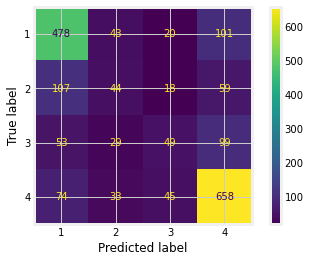

In [158]:
# plot matrix for Random Forest
plot_confusion_matrix(rf, X1_te, y1_te)
# predicting class 1 & 4 ok, but class imbalance appears to be impacting predictions for middle class

In [159]:
# look at features
rf_features = pd.DataFrame()
rf_features = pd.DataFrame([X1_tr.columns, rf.feature_importances_]).T
rf_features.rename(columns={0:'feature', 1:'coeff'}, inplace=True)

print(rf_features.shape)
rf_features.sort_values(by='coeff', ascending=False, inplace=True)
rf_features.head(10)

## seems reasonable

(395, 2)


,feature,coeff
313,class_Information Communication Technology,0.040652
394,employ_type_Full Time,0.034554
393,employ_type_Contract/Temp,0.03452
236,senior,0.022324
157,manager,0.017556
152,lead,0.014237
12,analyst,0.01354
328,class_sub_Architects,0.012824
317,class_Marketing Communications,0.012266
25,architect,0.011984


In [160]:
rf_features.tail(10)

,feature,coeff
59,co,0.000223
323,class_sub_Account Relationship Management,0.000221
83,data migration,0.000206
45,business analysts,0.000206
5,administration officer,0.000181
110,enterprise architect,0.000176
246,senior solution,0.000165
38,based darwin,0.000122
40,bi developer,0.000094
305,class_Community Services Development,0.000032


<AxesSubplot:xlabel='coeff', ylabel='feature'>

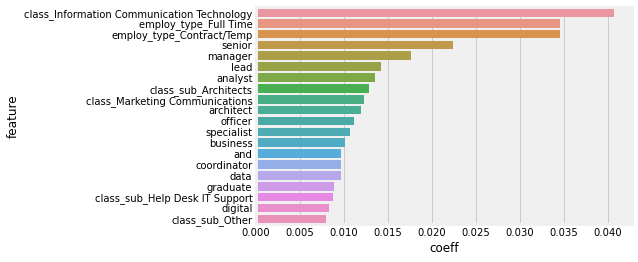

In [161]:
#plot top 20 features
plot_data = rf_features[:20]
# plt.barh(y=plot_data.feature, width=plot_data.coeff)
sns.barplot(y=plot_data.feature, x=plot_data.coeff)

### Models: Logistic Regression & SVM

In [162]:
# logistic regression model
lr = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial', max_iter=1000)
lr.fit(X1_tr, y1_tr)
y1_hat_lr = lr.predict(X1_te)
round(lr.score(X1_te,y1_te), 4)

0.6524

In [163]:
# SVM model
svm_model = SVC(random_state=42)
svm_model.fit(X1_tr, y1_tr)
yhat = svm_model.predict(X1_te)
round(svm_model.score(X1_te, y1_te), 4)

0.6686

In [164]:
confusion = pd.DataFrame(confusion_matrix(y1_te, y1_hat), 
                        index=['is_1', 'is_2', 'is_3', 'is_4'],
                        columns=[1,2,3,4])

print(classification_report(y1_te, y1_hat))
confusion

              precision    recall  f1-score   support

           1       0.67      0.74      0.71       642
           2       0.30      0.19      0.23       228
           3       0.37      0.21      0.27       230
           4       0.72      0.81      0.76       810

    accuracy                           0.64      1910
   macro avg       0.51      0.49      0.49      1910
weighted avg       0.61      0.64      0.62      1910



,1,2,3,4
is_1,478,43,20,101
is_2,107,44,18,59
is_3,53,29,49,99
is_4,74,33,45,658


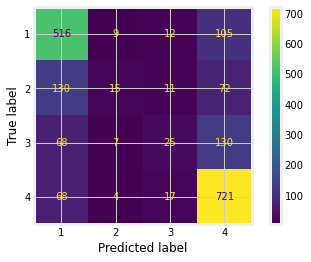

In [165]:
plot_confusion_matrix(svm_model, X1_te, y1_te)
# predicting class 1 & 4 ok, but class imbalance appears to be impacting predictions for middle classes


#### Results: 4 salary brackets
Not happy with middle brackets results, try merging middle brackets to have 3 relatively balanced classes to predict


[back to index](#index)

<a id='3_salary_brackets'></a>
## 3 Salary Brackets

In [166]:
# create 3 salary target groups
salary_group = list()
for i in y_df.index:
    if y_df.loc[i,'salary_0-80k'] == 1:
        salary_group.append(1)
    elif ((y_df.loc[i,'salary_80-100k'] == 1) | 
          (y_df.loc[i,'salary_100-120k'] == 1)):
        salary_group.append(2)
    elif y_df.loc[i,'salary_120k_plus'] == 1:
        salary_group.append(3)
    else:
        salary_group.append(0)

len(salary_group)

5787

In [167]:
y_df['salary_group'] = salary_group
print(y_df.shape)
y_df.head(2)

(5787, 6)


,job_id,salary_0-80k,salary_80-100k,salary_100-120k,salary_120k_plus,salary_group
2,52609378,1,0,0,0,1
4,52609686,1,0,0,0,1


In [168]:
# closer to balanced
y_df.salary_group.value_counts(normalize=True)

## previous group balance
# 4    0.423881
# 1    0.336444
# 3    0.120270
# 2    0.119406

3    0.423881
1    0.336444
2    0.239675
Name: salary_group, dtype: float64

### train-test split

In [169]:
# train-test split
X1_tr_df, X1_te_df, y1_tr, y1_te = train_test_split(X_df, y, test_size=0.33, 
                                                stratify=y, random_state=42)
print(X1_tr_df.shape, y1_tr.shape)
print(X1_te_df.shape, y1_te.shape)
X1_tr_df.head(2)

(3877, 5) (3877,)
(1910, 5) (1910,)


,job_id,title,class,class_sub,employ_type
5715,52597489,Customer Service & Administration Officer,Call Centre Customer Service,Customer Service Call Centre,Full Time
3582,52337132,Marketing Manager,Marketing Communications,Direct Marketing CRM,Full Time


### Dummy columns in train & test - then align test to train

In [170]:
# dummy for X train
df_dummies = pd.get_dummies(data=X1_tr_df, columns=['class', 'class_sub', 'employ_type'])
df_dummies.drop(columns=['job_id','title'], inplace=True)
print(df_dummies.shape)
df_dummies.head(2)

(3877, 95)


,class_Accounting,class_Administration Office Support,class_Advertising Arts Media,class_Banking Financial Services,class_Call Centre Customer Service,class_Community Services Development,class_Consulting Strategy,class_Design Architecture,class_Education Training,class_Engineering,class_Government Defence,class_Healthcare Medical,class_Human Resources Recruitment,class_Information Communication Technology,class_Insurance Superannuation,class_Legal,class_Manufacturing Transport Logistics,class_Marketing Communications,class_Mining Resources Energy,class_Real Estate Property,class_Retail Consumer Products,class_Sales,class_Science Technology,class_sub_Account Relationship Management,class_sub_Actuarial,class_sub_Administrative Assistants,class_sub_Analysis Reporting,class_sub_Analysts,class_sub_Architects,class_sub_Audit Internal,class_sub_Banking Business,class_sub_Biological Biomedical Sciences,class_sub_Brand Management,class_sub_BusinessSystems Analysts,class_sub_CivilStructural Engineering,class_sub_Client Sales Administration,class_sub_ClinicalMedical Research,class_sub_Compliance Risk,class_sub_Consultants,class_sub_Consulting Generalist HR,class_sub_Credit,class_sub_Customer Service Call Centre,class_sub_Database Development Administration,class_sub_DevelopersProgrammers,class_sub_Digital Search Marketing,class_sub_Direct Marketing CRM,class_sub_ElectricalElectronic Engineering,class_sub_Engineering Network,class_sub_Engineering Software,class_sub_Environmental Earth Geosciences,class_sub_Financial Accounting Reporting,class_sub_Financial Managers Controllers,class_sub_Funds Management,class_sub_Government Federal,class_sub_Government Local,class_sub_Government State,class_sub_Help Desk IT Support,class_sub_Laboratory Technical Services,class_sub_Management,class_sub_Management Accounting Budgeting,class_sub_Management Change Consulting,class_sub_Market Research Analysis,class_sub_Marketing AssistantsCoordinators,class_sub_Marketing Communications,class_sub_Mathematics Statistics Information Sciences,class_sub_Media Strategy Planning Buying,class_sub_Mining Engineering Maintenance,class_sub_Mining Exploration Geoscience,class_sub_Networks Systems Administration,class_sub_New Business Development,class_sub_Other,class_sub_Payroll,class_sub_Pharmaceuticals Medical Devices,class_sub_Planning,class_sub_Policy Planning Regulation,class_sub_Product Management Development,class_sub_Production Planning Scheduling,class_sub_Programme Project Management,class_sub_Purchasing Procurement Inventory,class_sub_Quality Assurance Control,class_sub_Recruitment Internal,class_sub_Research Fellowships,class_sub_Sales Pre Post,class_sub_Sales RepresentativesConsultants,class_sub_Security,class_sub_Strategy Planning,class_sub_Systems Engineering,class_sub_Taxation,class_sub_Teaching Tertiary,class_sub_Team Leaders,class_sub_Testing Quality Assurance,class_sub_Web Development Production,class_sub_Web Interaction Design,employ_type_Contract/Temp,employ_type_Full Time
5715,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [171]:
# dummy for X test
df_te_dummies = pd.get_dummies(data=X1_te_df, columns=['class', 'class_sub', 'employ_type'])
df_te_dummies.drop(columns=['job_id','title'], inplace=True)
print(df_te_dummies.shape)
df_te_dummies.head(2)

(1910, 95)


,class_Accounting,class_Administration Office Support,class_Advertising Arts Media,class_Banking Financial Services,class_Call Centre Customer Service,class_Community Services Development,class_Consulting Strategy,class_Design Architecture,class_Education Training,class_Engineering,class_Government Defence,class_Healthcare Medical,class_Human Resources Recruitment,class_Information Communication Technology,class_Insurance Superannuation,class_Legal,class_Manufacturing Transport Logistics,class_Marketing Communications,class_Mining Resources Energy,class_Real Estate Property,class_Retail Consumer Products,class_Sales,class_Science Technology,class_sub_Actuarial,class_sub_Administrative Assistants,class_sub_Analysis Reporting,class_sub_Analysts,class_sub_Architects,class_sub_Audit Internal,class_sub_Banking Business,class_sub_Biological Biomedical Sciences,class_sub_Brand Management,class_sub_BusinessSystems Analysts,class_sub_CivilStructural Engineering,class_sub_Client Sales Administration,class_sub_ClinicalMedical Research,class_sub_Compliance Risk,class_sub_Consultants,class_sub_Consulting Generalist HR,class_sub_Credit,class_sub_Customer Service Call Centre,class_sub_Database Development Administration,class_sub_DevelopersProgrammers,class_sub_Digital Search Marketing,class_sub_Direct Marketing CRM,class_sub_ElectricalElectronic Engineering,class_sub_Engineering Network,class_sub_Engineering Software,class_sub_Environmental Earth Geosciences,class_sub_Financial Accounting Reporting,class_sub_Financial Managers Controllers,class_sub_Funds Management,class_sub_Government Federal,class_sub_Government Local,class_sub_Government State,class_sub_Health Safety Environment,class_sub_Help Desk IT Support,class_sub_Laboratory Technical Services,class_sub_Management,class_sub_Management Accounting Budgeting,class_sub_Management Change Consulting,class_sub_Market Research Analysis,class_sub_Marketing AssistantsCoordinators,class_sub_Marketing Communications,class_sub_Mathematics Statistics Information Sciences,class_sub_Media Strategy Planning Buying,class_sub_Mining Engineering Maintenance,class_sub_Mining Exploration Geoscience,class_sub_Networks Systems Administration,class_sub_New Business Development,class_sub_Other,class_sub_Payroll,class_sub_Pharmaceuticals Medical Devices,class_sub_Planning,class_sub_Policy Planning Regulation,class_sub_Product Management Development,class_sub_Production Planning Scheduling,class_sub_Programme Project Management,class_sub_Purchasing Procurement Inventory,class_sub_Quality Assurance Control,class_sub_Recruitment Internal,class_sub_Research Fellowships,class_sub_Sales Pre Post,class_sub_Sales RepresentativesConsultants,class_sub_Security,class_sub_Strategy Planning,class_sub_Systems Engineering,class_sub_Taxation,class_sub_Teaching Tertiary,class_sub_Team Leaders,class_sub_Testing Quality Assurance,class_sub_Web Development Production,class_sub_Web Interaction Design,employ_type_Contract/Temp,employ_type_Full Time
5213,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2869,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [172]:
# looks like the same dummies in test & train, but best to make sure
df_dummies, df_te_dummies = df_dummies.align(df_te_dummies, join='left', axis=1)

# fill any nans with 0
df_te_dummies.fillna(value=0, inplace=True)
print(df_dummies.shape, df_te_dummies.shape)

(3877, 95) (1910, 95)


### Tokenize in train & test, align - then add to dummied columns

In [173]:
# load in custom stopword list for title column
title_ignore = pd.read_csv('./datasets/stopwords_title.csv', header=None)
title_ignore = list(pd.Series(title_ignore[0]))

In [174]:
# check that it imported ok
print(type(title_ignore))
# title_ignore

<class 'list'>


In [175]:
X1_te_df.columns, X1_tr_df.columns

(Index(['job_id', 'title', 'class', 'class_sub', 'employ_type'], dtype='object'),
 Index(['job_id', 'title', 'class', 'class_sub', 'employ_type'], dtype='object'))

In [176]:
# use good parameters
vect = CountVectorizer(lowercase=True, ngram_range=(1,2), min_df=5, 
                       stop_words=title_ignore, max_features=300)

wf = vect.fit_transform(X1_tr_df['title'])
wf_te = vect.transform(X1_te_df['title'])

In [177]:
count_list = wf.toarray().sum(axis=0)
word_list = vect.get_feature_names()

In [178]:
# train
dtm = wf.toarray()
print(dtm.shape)
dtm_df = pd.DataFrame(dtm, columns=word_list)
print(dtm_df.shape)
dtm_df.head(2)

(3877, 300)
(3877, 300)


,account,account manager,accountant,acquisition,administration,administration officer,administrator,advisor,agile,agile business,analysis,analyst,analyst digital,analyst financial,analysts,analytics,and,application,application support,applications,aps,aps6,architect,assistant,associate,assurance,audit,australia,automation,aws,azure,ba,banking,based,based darwin,bi,bi developer,brisbane,business,business analyst,business analysts,business development,business intelligence,business partner,business systems,campaign,centre,chain,change,client,clinical,cloud,cloud engineer,co,commerce,commercial,commercial analyst,communications,compliance,consultant,consultants,content,contract,control,coordinator,credit,credit analyst,crm,customer,customer service,cyber,cyber security,darwin,data,data analyst,data analytics,data engineer,data migration,database,delivery,demand,design,designer,desk,developer,developers,development,development manager,devops,devops engineer,digital,digital marketing,director,division,dynamics,ecommerce,el1,end,end developer,energy,engagement,engineer,engineering,engineers,enterprise,enterprise architect,erp,etl,executive,experience,fellow,finance,financial,financial analyst,fixed,fixed term,for,full,full stack,functional,geologist,governance,government,graduate,group,head,head of,health,hr,human,ict,implementation,implementation consultant,industry,information,information management,information security,infrastructure,integration,intelligence,internal,inventory,investment,java,junior,laboratory,lead,leader,learning,lecturer,level,management,manager,marketing,marketing and,marketing coordinator,marketing executive,marketing manager,marketing specialist,master,mdm,media,melbourne,microsoft,mid,migration,modeller,multiple,national,net,net developer,network,nsw,of,office,officer,officers,operations,operations analyst,opportunities,or,oracle,owner,partner,payroll,performance,perth,phd,phd scholarship,planner,planning,platform,policy,portfolio,positions,power,power bi,pricing,principal,process,procurement,product,product manager,product owner,production,professor,program,programmer,project,project manager,project officer,projects,python,python developer,qa,quality,remote,reporting,reporting analyst,representative,research,research assistant,retail,risk,roles,saas,sales,salesforce,sap,scholarship,scientist,security,security analyst,security engineer,senior,senior analyst,senior business,senior consultant,senior data,senior devops,senior full,senior manager,senior project,senior software,senior solution,senior test,seo,service,service desk,services,sharepoint,social,social media,software,software developer,software engineer,solution,solution architect,solution designer,solutions,solutions architect,specialist,sql,stack,stack developer,start,strategy,supply,supply chain,support,support analyst,support engineer,support officer,sydney,system,systems,systems analyst,systems engineer,talent,team,tech,tech lead,technical,technical business,technical lead,technical support,technician,technology,term,term contract,test,test analyst,tester,time,to,transformation,ui,up,ux,workforce
0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [179]:
# test
dtm_te = wf_te.toarray()
print(dtm_te.shape)
dtm_te_df = pd.DataFrame(dtm_te, columns=word_list)
print(dtm_te_df.shape)
dtm_te_df.head(2)

(1910, 300)
(1910, 300)


,account,account manager,accountant,acquisition,administration,administration officer,administrator,advisor,agile,agile business,analysis,analyst,analyst digital,analyst financial,analysts,analytics,and,application,application support,applications,aps,aps6,architect,assistant,associate,assurance,audit,australia,automation,aws,azure,ba,banking,based,based darwin,bi,bi developer,brisbane,business,business analyst,business analysts,business development,business intelligence,business partner,business systems,campaign,centre,chain,change,client,clinical,cloud,cloud engineer,co,commerce,commercial,commercial analyst,communications,compliance,consultant,consultants,content,contract,control,coordinator,credit,credit analyst,crm,customer,customer service,cyber,cyber security,darwin,data,data analyst,data analytics,data engineer,data migration,database,delivery,demand,design,designer,desk,developer,developers,development,development manager,devops,devops engineer,digital,digital marketing,director,division,dynamics,ecommerce,el1,end,end developer,energy,engagement,engineer,engineering,engineers,enterprise,enterprise architect,erp,etl,executive,experience,fellow,finance,financial,financial analyst,fixed,fixed term,for,full,full stack,functional,geologist,governance,government,graduate,group,head,head of,health,hr,human,ict,implementation,implementation consultant,industry,information,information management,information security,infrastructure,integration,intelligence,internal,inventory,investment,java,junior,laboratory,lead,leader,learning,lecturer,level,management,manager,marketing,marketing and,marketing coordinator,marketing executive,marketing manager,marketing specialist,master,mdm,media,melbourne,microsoft,mid,migration,modeller,multiple,national,net,net developer,network,nsw,of,office,officer,officers,operations,operations analyst,opportunities,or,oracle,owner,partner,payroll,performance,perth,phd,phd scholarship,planner,planning,platform,policy,portfolio,positions,power,power bi,pricing,principal,process,procurement,product,product manager,product owner,production,professor,program,programmer,project,project manager,project officer,projects,python,python developer,qa,quality,remote,reporting,reporting analyst,representative,research,research assistant,retail,risk,roles,saas,sales,salesforce,sap,scholarship,scientist,security,security analyst,security engineer,senior,senior analyst,senior business,senior consultant,senior data,senior devops,senior full,senior manager,senior project,senior software,senior solution,senior test,seo,service,service desk,services,sharepoint,social,social media,software,software developer,software engineer,solution,solution architect,solution designer,solutions,solutions architect,specialist,sql,stack,stack developer,start,strategy,supply,supply chain,support,support analyst,support engineer,support officer,sydney,system,systems,systems analyst,systems engineer,talent,team,tech,tech lead,technical,technical business,technical lead,technical support,technician,technology,term,term contract,test,test analyst,tester,time,to,transformation,ui,up,ux,workforce
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [180]:
# looks like the same tokens in test & train, but best to make sure
dtm_df, dtm_te_df = dtm_df.align(dtm_te_df, join='left', axis=1)

# fill any nans with 0
dtm_te_df.fillna(value=0, inplace=True)
print(dtm_df.shape, dtm_te_df.shape)

(3877, 300) (1910, 300)


### Join title_tokens & dummies into predictor matrix

In [181]:
# TRAIN: concatenate title_tokens (dtm_df) with dummies (df_dummies)
X1_tr = pd.concat([dtm_df.reset_index(drop=True), df_dummies.reset_index(drop=True)], axis=1)
print(dtm_df.shape, df_dummies.shape)
print(X1_tr.shape)
X1_tr.head(2)


(3877, 300) (3877, 95)
(3877, 395)


,account,account manager,accountant,acquisition,administration,administration officer,administrator,advisor,agile,agile business,analysis,analyst,analyst digital,analyst financial,analysts,analytics,and,application,application support,applications,aps,aps6,architect,assistant,associate,assurance,audit,australia,automation,aws,azure,ba,banking,based,based darwin,bi,bi developer,brisbane,business,business analyst,business analysts,business development,business intelligence,business partner,business systems,campaign,centre,chain,change,client,clinical,cloud,cloud engineer,co,commerce,commercial,commercial analyst,communications,compliance,consultant,consultants,content,contract,control,coordinator,credit,credit analyst,crm,customer,customer service,cyber,cyber security,darwin,data,data analyst,data analytics,data engineer,data migration,database,delivery,demand,design,designer,desk,developer,developers,development,development manager,devops,devops engineer,digital,digital marketing,director,division,dynamics,ecommerce,el1,end,end developer,energy,engagement,engineer,engineering,engineers,enterprise,enterprise architect,erp,etl,executive,experience,fellow,finance,financial,financial analyst,fixed,fixed term,for,full,full stack,functional,geologist,governance,government,graduate,group,head,head of,health,hr,human,ict,implementation,implementation consultant,industry,information,information management,information security,infrastructure,integration,intelligence,internal,inventory,investment,java,junior,laboratory,lead,leader,learning,lecturer,level,management,manager,marketing,marketing and,marketing coordinator,marketing executive,marketing manager,marketing specialist,master,mdm,media,melbourne,microsoft,mid,migration,modeller,multiple,national,net,net developer,network,nsw,of,office,officer,officers,operations,operations analyst,opportunities,or,oracle,owner,partner,payroll,performance,perth,phd,phd scholarship,planner,planning,platform,policy,portfolio,positions,power,power bi,pricing,principal,process,procurement,product,product manager,product owner,production,professor,program,programmer,project,project manager,project officer,projects,python,python developer,qa,quality,remote,reporting,reporting analyst,representative,research,research assistant,retail,risk,roles,saas,sales,salesforce,sap,scholarship,scientist,security,security analyst,security engineer,senior,senior analyst,senior business,senior consultant,senior data,senior devops,senior full,senior manager,senior project,senior software,senior solution,senior test,seo,service,service desk,services,sharepoint,social,social media,software,software developer,software engineer,solution,solution architect,solution designer,solutions,solutions architect,specialist,sql,stack,stack developer,start,strategy,supply,supply chain,support,support analyst,support engineer,support officer,sydney,system,systems,systems analyst,systems engineer,talent,team,tech,tech lead,technical,technical business,technical lead,technical support,technician,technology,term,term contract,test,test analyst,tester,time,to,transformation,ui,up,ux,workforce,class_Accounting,class_Administration Office Support,class_Advertising Arts Media,class_Banking Financial Services,class_Call Centre Customer Service,class_Community Services Development,class_Consulting Strategy,class_Design Architecture,class_Education Training,class_Engineering,class_Government Defence,class_Healthcare Medical,class_Human Resources Recruitment,class_Information Communication Technology,class_Insurance Superannuation,class_Legal,class_Manufacturing Transport Logistics,class_Marketing Communications,class_Mining Resources Energy,class_Real Estate Property,class_Retail Consumer Products,class_Sales,class_Science Technology,class_sub_Account Relationship Management,class_sub_Actuarial,class_sub_Administrative Assistants,class_sub_Analysis Reporting,class_sub_Analysts,class_sub_Architects,class_sub_Audit Internal,class_sub_Banking Business

In [182]:
# TEST: concatenate title_tokens (dtm_te_df) with dummies (df_te_dummies)
X1_te = pd.concat([dtm_te_df.reset_index(drop=True), df_te_dummies.reset_index(drop=True)], axis=1)
print(dtm_te_df.shape, df_te_dummies.shape)
print(X1_te.shape)
X1_te.head(2)


(1910, 300) (1910, 95)
(1910, 395)


,account,account manager,accountant,acquisition,administration,administration officer,administrator,advisor,agile,agile business,analysis,analyst,analyst digital,analyst financial,analysts,analytics,and,application,application support,applications,aps,aps6,architect,assistant,associate,assurance,audit,australia,automation,aws,azure,ba,banking,based,based darwin,bi,bi developer,brisbane,business,business analyst,business analysts,business development,business intelligence,business partner,business systems,campaign,centre,chain,change,client,clinical,cloud,cloud engineer,co,commerce,commercial,commercial analyst,communications,compliance,consultant,consultants,content,contract,control,coordinator,credit,credit analyst,crm,customer,customer service,cyber,cyber security,darwin,data,data analyst,data analytics,data engineer,data migration,database,delivery,demand,design,designer,desk,developer,developers,development,development manager,devops,devops engineer,digital,digital marketing,director,division,dynamics,ecommerce,el1,end,end developer,energy,engagement,engineer,engineering,engineers,enterprise,enterprise architect,erp,etl,executive,experience,fellow,finance,financial,financial analyst,fixed,fixed term,for,full,full stack,functional,geologist,governance,government,graduate,group,head,head of,health,hr,human,ict,implementation,implementation consultant,industry,information,information management,information security,infrastructure,integration,intelligence,internal,inventory,investment,java,junior,laboratory,lead,leader,learning,lecturer,level,management,manager,marketing,marketing and,marketing coordinator,marketing executive,marketing manager,marketing specialist,master,mdm,media,melbourne,microsoft,mid,migration,modeller,multiple,national,net,net developer,network,nsw,of,office,officer,officers,operations,operations analyst,opportunities,or,oracle,owner,partner,payroll,performance,perth,phd,phd scholarship,planner,planning,platform,policy,portfolio,positions,power,power bi,pricing,principal,process,procurement,product,product manager,product owner,production,professor,program,programmer,project,project manager,project officer,projects,python,python developer,qa,quality,remote,reporting,reporting analyst,representative,research,research assistant,retail,risk,roles,saas,sales,salesforce,sap,scholarship,scientist,security,security analyst,security engineer,senior,senior analyst,senior business,senior consultant,senior data,senior devops,senior full,senior manager,senior project,senior software,senior solution,senior test,seo,service,service desk,services,sharepoint,social,social media,software,software developer,software engineer,solution,solution architect,solution designer,solutions,solutions architect,specialist,sql,stack,stack developer,start,strategy,supply,supply chain,support,support analyst,support engineer,support officer,sydney,system,systems,systems analyst,systems engineer,talent,team,tech,tech lead,technical,technical business,technical lead,technical support,technician,technology,term,term contract,test,test analyst,tester,time,to,transformation,ui,up,ux,workforce,class_Accounting,class_Administration Office Support,class_Advertising Arts Media,class_Banking Financial Services,class_Call Centre Customer Service,class_Community Services Development,class_Consulting Strategy,class_Design Architecture,class_Education Training,class_Engineering,class_Government Defence,class_Healthcare Medical,class_Human Resources Recruitment,class_Information Communication Technology,class_Insurance Superannuation,class_Legal,class_Manufacturing Transport Logistics,class_Marketing Communications,class_Mining Resources Energy,class_Real Estate Property,class_Retail Consumer Products,class_Sales,class_Science Technology,class_sub_Account Relationship Management,class_sub_Actuarial,class_sub_Administrative Assistants,class_sub_Analysis Reporting,class_sub_Analysts,class_sub_Architects,class_sub_Audit Internal,class_sub_Banking Business

### Models: Decision Tree & Random Forest

In [183]:
# reminder of X/y sizes
X1_tr.shape, X1_te.shape, y1_tr.shape, y1_te.shape 

((3877, 395), (1910, 395), (3877,), (1910,))

In [184]:
# full depth over-fitted decision tree
dtc = DecisionTreeClassifier(max_depth=None, max_features='auto')
dtc.fit(X1_tr, y1_tr)
print('dtc acc:', dtc.score(X1_te, y1_te))

dtc acc: 0.6146596858638743


In [185]:
# random forest
rf = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='auto')
rf.fit(X1_tr, y1_tr)
y1_hat = rf.predict(X1_te)
print('rf acc:', accuracy_score(y1_te, y1_hat))

rf acc: 0.6696335078534031


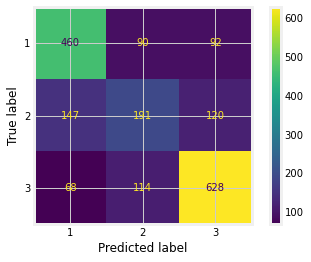

In [186]:
# plot matrix for Random Forest
plot_confusion_matrix(rf, X1_te, y1_te)
# predicting class 1 & 3 ok, but still having issues with class 2

In [187]:
# look at features
rf_features = pd.DataFrame()
rf_features = pd.DataFrame([X1_tr.columns, rf.feature_importances_]).T
rf_features.rename(columns={0:'feature', 1:'coeff'}, inplace=True)

print(rf_features.shape)
rf_features.sort_values(by='coeff', ascending=False, inplace=True)
rf_features.head(10)

## seems reasonable

(395, 2)


,feature,coeff
313,class_Information Communication Technology,0.044939
393,employ_type_Contract/Temp,0.038129
394,employ_type_Full Time,0.037361
234,senior,0.024308
152,manager,0.01645
328,class_sub_Architects,0.013695
146,lead,0.013508
11,analyst,0.013059
22,architect,0.012789
175,officer,0.012004


In [188]:
rf_features.tail(10)

,feature,coeff
323,class_sub_Account Relationship Management,0.000236
5,administration officer,0.000232
244,senior solution,0.000222
77,data migration,0.000219
154,marketing and,0.000214
40,business analysts,0.000185
379,class_sub_Quality Assurance Control,0.000176
34,based darwin,0.000113
36,bi developer,0.000107
305,class_Community Services Development,0.000053


<AxesSubplot:xlabel='coeff', ylabel='feature'>

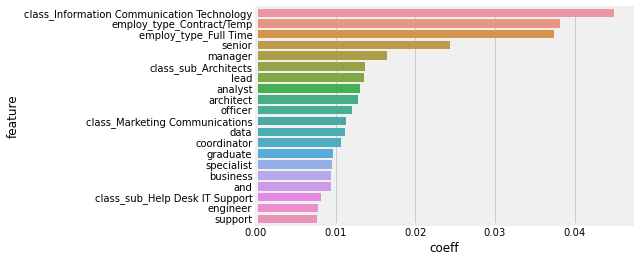

In [189]:
#plot top 20 features
plot_data = rf_features[:20]
# plt.barh(y=plot_data.feature, width=plot_data.coeff)
sns.barplot(y=plot_data.feature, x=plot_data.coeff)

### Models: Logistic Regression & SVM

In [190]:
# logistic regression model
lr = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial', max_iter=1000)
lr.fit(X1_tr, y1_tr)
y1_hat_lr = lr.predict(X1_te)
round(lr.score(X1_te,y1_te), 4)

0.6775

In [191]:
# SVM model
svm_model = SVC(random_state=42)
svm_model.fit(X1_tr, y1_tr)
yhat = svm_model.predict(X1_te)
round(svm_model.score(X1_te, y1_te), 4)

0.6932

In [192]:
# SVM
confusion = pd.DataFrame(confusion_matrix(y1_te, yhat), 
                        index=['is_1', 'is_2', 'is_3'],
                        columns=[1,2,3])

print(classification_report(y1_te, yhat))
confusion

              precision    recall  f1-score   support

           1       0.74      0.72      0.73       642
           2       0.49      0.46      0.47       458
           3       0.76      0.81      0.78       810

    accuracy                           0.69      1910
   macro avg       0.66      0.66      0.66      1910
weighted avg       0.69      0.69      0.69      1910



,1,2,3
is_1,461,98,83
is_2,128,210,120
is_3,38,119,653


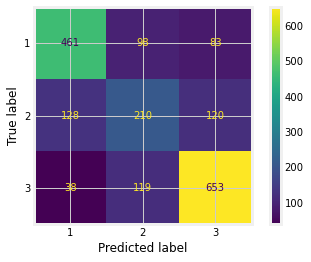

In [193]:
plot_confusion_matrix(svm_model, X1_te, y1_te)
# predicting class 1 & 3 ok, but middle class ...

#### Results: 3 salary brackets
Middle bracket still poor results. Choose Logistic Regression as preferred model because of decent predictions for Low/High AND coefficients clearly demonstrate factors for each of the classes, including the muddled middle class.

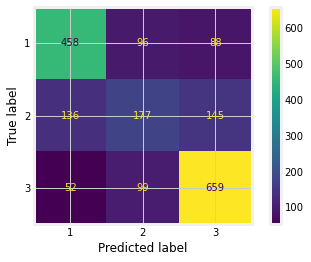

In [194]:
plot_confusion_matrix(lr, X1_te, y1_te)

In [195]:
lr.coef_.shape

(3, 395)

In [196]:
X1_tr.columns

Index(['account', 'account manager', 'accountant', 'acquisition',
       'administration', 'administration officer', 'administrator', 'advisor',
       'agile', 'agile business',
       ...
       'class_sub_Strategy Planning', 'class_sub_Systems Engineering',
       'class_sub_Taxation', 'class_sub_Teaching Tertiary',
       'class_sub_Team Leaders', 'class_sub_Testing Quality Assurance',
       'class_sub_Web Development Production',
       'class_sub_Web Interaction Design', 'employ_type_Contract/Temp',
       'employ_type_Full Time'],
      dtype='object', length=395)

In [197]:
# put features, coefs & abs coef into a sorted dataframe
def coefs_to_dataframe(feature_list, coef_list):
    df = pd.DataFrame({'feature': feature_list,
                      'coefs': coef_list,
                      'abs_coefs': np.abs(coef_list)})
    df.sort_values('abs_coefs', inplace=True, ascending=False)
    return df

In [198]:
# put features & coefs into a dataframe - class 1
lr_coefs_1 = coefs_to_dataframe(list(X1_tr.columns), lr.coef_[0])
lr_coefs_1

,feature,coefs,abs_coefs
92,director,-2.292789,2.292789
123,graduate,2.124698,2.124698
144,junior,1.670085,1.670085
205,professor,-1.541298,1.541298
23,assistant,1.462688,1.462688
125,head,-1.402263,1.402263
64,coordinator,1.267755,1.267755
187,phd,1.257440,1.257440
198,principal,-1.231879,1.231879
120,geologist,-1.199714,1.199714


In [199]:
# put features & coefs into a dataframe - class 2
lr_coefs_2 = coefs_to_dataframe(list(X1_tr.columns), lr.coef_[1])
lr_coefs_2

,feature,coefs,abs_coefs
73,data,-1.128892,1.128892
125,head,1.008612,1.008612
250,sharepoint,0.986266,0.986266
104,enterprise,-0.981901,0.981901
113,financial analyst,0.954453,0.954453
214,qa,0.945887,0.945887
149,lecturer,0.940716,0.940716
225,saas,0.908366,0.908366
85,developers,-0.870605,0.870605
123,graduate,-0.855307,0.855307


In [200]:
# put features & coefs into a dataframe - class 3
lr_coefs_3 = coefs_to_dataframe(list(X1_tr.columns), lr.coef_[2])
lr_coefs_3

,feature,coefs,abs_coefs
92,director,1.878585,1.878585
205,professor,1.843912,1.843912
318,class_Mining Resources Energy,1.629898,1.629898
64,coordinator,-1.513025,1.513025
198,principal,1.275419,1.275419
123,graduate,-1.269391,1.269391
144,junior,-1.248792,1.248792
356,class_sub_Help Desk IT Support,-1.163853,1.163853
23,assistant,-1.060749,1.060749
126,head of,1.048211,1.048211


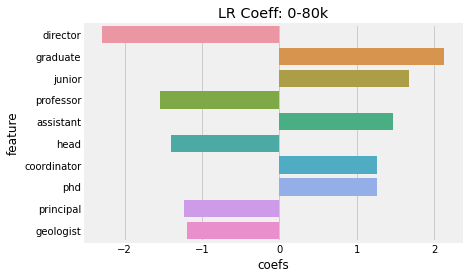

In [201]:
# visualise the coefficients of top 20 magnitude coefficients
# plt.figure(figsize=(10,10))

g = sns.barplot(data=lr_coefs_1[0:10], y='feature', x='coefs', orient='h')
g.set_title('LR Coeff: 0-80k');


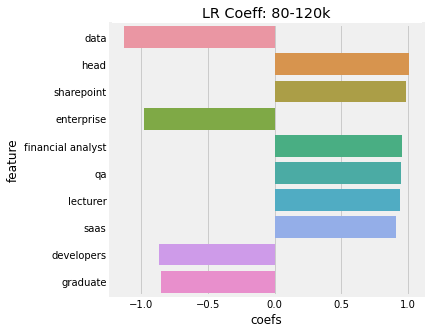

In [202]:
# visualise the coefficients of top 20 magnitude coefficients
plt.figure(figsize=(5,5))

g = sns.barplot(data=lr_coefs_2[0:10], y='feature', x='coefs', orient='h')
g.set_title('LR Coeff: 80-120k');

## highest magnitude coefs have a number of Neighbourhoods as expected 
## but Garage(=none) being the biggest influence on SalePrice is more evidence that this isn't the right model to use

## >> onward to the next model!

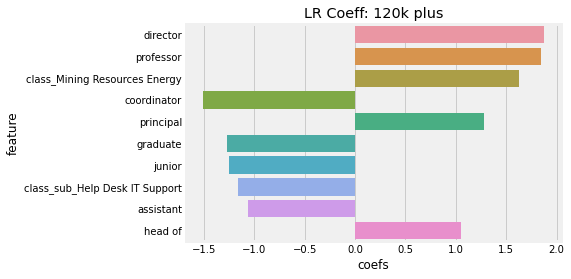

In [203]:
# visualise the coefficients of top 20 magnitude coefficients
# plt.figure(figsize=(20,20))

g = sns.barplot(data=lr_coefs_3[0:10], y='feature', x='coefs', orient='h')
g.set_title('LR Coeff: 120k plus');

## highest magnitude coefs have a number of Neighbourhoods as expected 
## but Garage(=none) being the biggest influence on SalePrice is more evidence that this isn't the right model to use

## >> onward to the next model!

---
[back to index](#index)
<a id='q2'></a>
## Q2: Job Category Factors
<br>
Features in predictor matrix:  

- description (TFIDF tokenized)
  
Target:  
- grouped search category (as class labels)

### Create class labels for job titles

In [204]:
# check joblist dataset
print(joblist_df.columns, '\n')
joblist_df.info()

Index(['job_id', 'title', 'location', 'loc_area', 'classification',
       'class_sub', 'desc_short', 'salary', 'bracket_count', 'salary_0-80k',
       'salary_80-100k', 'salary_100-120k', 'salary_120k_plus', 'search_AI',
       'search_BI', 'search_DArch', 'search_DE', 'search_ML', 'search_DA',
       'search_DS', 'search_count'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12109 entries, 0 to 12108
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_id            12109 non-null  object
 1   title             12109 non-null  object
 2   location          12109 non-null  object
 3   loc_area          8015 non-null   object
 4   classification    12109 non-null  object
 5   class_sub         12109 non-null  object
 6   desc_short        12109 non-null  object
 7   salary            4017 non-null   object
 8   bracket_count     12109 non-null  int64 
 9   salary_0-80k      1210

In [205]:
# how many jobs appeared in multiple searches
joblist_df.search_count.value_counts()

1    8192
2    2225
3     688
4     420
5     396
6     176
7      12
Name: search_count, dtype: int64

In [206]:
# prepare predictor dataframe
df2 = joblist_df.loc[:,('job_id', 'title', 'search_count', 'bracket_count')]
print(df2.shape)
df2.head(3)

(12109, 4)


,job_id,title,search_count,bracket_count
0,52580219,Data Analyst/Developer,4,2
1,52580220,Data Analyst/Developer,4,2
2,52609378,Data Scientist,4,1


In [207]:
# create 3 classes: Data Scientist, Data Specialist, Data Analyst
# prioritising the order so a job falls into only one category & 
# they are filled so everything doesn't end up in Data Analyst

job_category = list()

for i in joblist_df.index:
    if joblist_df.loc[i,'search_DS'] == 1:
        job_category.append(2)
    elif ((joblist_df.loc[i,'search_AI'] == 1) 
          | (joblist_df.loc[i,'search_BI'] == 1) 
          | (joblist_df.loc[i,'search_DArch'] == 1) 
          | (joblist_df.loc[i,'search_DE'] == 1) 
          | (joblist_df.loc[i,'search_ML'] == 1) 
          ):
        job_category.append(3)
    else:
        # assume the rest are all Data Analysts
        job_category.append(1)

len(job_category)


12109

In [208]:
# add job_category class lables to predictor dataframe
df2['job_category'] = job_category
print(df2.shape)
df2.head(3)

(12109, 5)


,job_id,title,search_count,bracket_count,job_category
0,52580219,Data Analyst/Developer,4,2,2
1,52580220,Data Analyst/Developer,4,2,2
2,52609378,Data Scientist,4,1,2


In [209]:
# check class balance
print(df2.job_category.value_counts(), '\n')
print(df2.job_category.value_counts(normalize=True))

## look at the properties of the classes & see if there's an obvious grouping  
## to balance class 1 to be closer to the other classes 

1    6433
3    2900
2    2776
Name: job_category, dtype: int64 

1    0.531258
3    0.239491
2    0.229251
Name: job_category, dtype: float64


In [210]:
# check how many jobs in category 3 (Data Specialist) appear in multiple groupings
print(df2[df2.job_category == 3].search_count.value_counts(), '\n')
print(df2[df2.job_category == 3].bracket_count.value_counts())

## nothing obvious

2    1386
1    1059
3     310
4     131
5      13
6       1
Name: search_count, dtype: int64 

1    1346
2    1087
3     467
Name: bracket_count, dtype: int64


In [211]:
# check how many jobs in category 2 (Data Scientist) appear in multiple groupings
print(df2[df2.job_category == 2].search_count.value_counts(), '\n')
print(df2[df2.job_category == 2].bracket_count.value_counts())

## nothing obvious

2    839
1    700
5    383
3    378
4    289
6    175
7     12
Name: search_count, dtype: int64 

2    1228
1     894
3     654
Name: bracket_count, dtype: int64


In [212]:
# check how many jobs in category 1 (Data Analyst) appear in multiple groupings
print(df2[df2.job_category == 1].search_count.value_counts(), '\n')
print(df2[df2.job_category == 1].bracket_count.value_counts())

## excellent - reduce to only the jobs in one salary bracket

1    6433
Name: search_count, dtype: int64 

1    3547
2    2294
3     592
Name: bracket_count, dtype: int64


In [213]:
# drop rows for category=1 where bracket_count >1
drop_rows = df2[(df2.job_category == 1) & (df2.bracket_count > 1)].index
len(drop_rows)
## 2294 + 592 = 2886

2886

In [214]:
df2 = df2.drop(index=list(drop_rows))
df2.reset_index(drop=True, inplace=True)
print(df2.shape)
df2.job_category.value_counts(normalize=True)

## plenty of rows of data, reasonably balanced classes

(9223, 5)


1    0.384582
3    0.314431
2    0.300987
Name: job_category, dtype: float64

In [215]:
# check the dataframes
df2.columns, jobdetail_df.columns

(Index(['job_id', 'title', 'search_count', 'bracket_count', 'job_category'], dtype='object'),
 Index(['job_id', 'title', 'company', 'salary', 'employ_type', 'desc_full'], dtype='object'))

In [216]:
# merge full job description onto df2
df2 = df2.merge(jobdetail_df[['job_id', 'desc_full']], how='left', on='job_id')
print(df2.shape)
df2.head()

## 9223 rows

(9223, 6)


,job_id,title,search_count,bracket_count,job_category,desc_full
0,52580219,Data Analyst/Developer,4,2,2,The Data Analyst/ Developer is a role within B...
1,52580220,Data Analyst/Developer,4,2,2,The Data Analyst/ Developer is a role within B...
2,52609378,Data Scientist,4,1,2,Seeking a Data Scientist to be involved in a r...
3,52605022,Data Analyst,3,3,2,THE OPPORTUNITY Launch your career in Data An...
4,52609686,Graduate Data Consultants,4,1,2,"Here at Altis, we're all about our people! Sup..."


In [217]:
# save dataframe
df2.to_csv('./datasets/dataframe_q2_prepared.csv', index=False)

In [218]:
# load dataframe
df2 = pd.read_csv('./datasets/dataframe_q2_prepared.csv')
df2['job_id'] = df2['job_id'].astype('object')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9223 entries, 0 to 9222
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   job_id         9223 non-null   object
 1   title          9223 non-null   object
 2   search_count   9223 non-null   int64 
 3   bracket_count  9223 non-null   int64 
 4   job_category   9223 non-null   int64 
 5   desc_full      9223 non-null   object
dtypes: int64(3), object(3)
memory usage: 432.5+ KB


---
[back to index](#index)
<a id='q2_matrix'></a>
## Prepare predictor matrix
<br>


### Prepare description - remove punctuation and numbers

In [219]:
# replace non-breaking spaces
df2['desc_full'] = df2.desc_full.map(lambda x: x.replace("\xa0", ' '))

## remove all punctuation & numbers, 
## keep hyphenated etc words & then replace with a space

df2['desc_full'] = df2.desc_full.map(lambda x: ''.join([y for y in list(x.lower()) 
                                          if y in string.ascii_lowercase 
                                                        +" -" +"." +"/"]))

# I'm sure there's an easier way - but this works
df2['desc_full'] = df2.desc_full.map(lambda x: x.replace('-', ' '))
df2['desc_full'] = df2.desc_full.map(lambda x: x.replace('.', ' '))
df2['desc_full'] = df2.desc_full.map(lambda x: x.replace('.', ' '))

In [220]:
# slice full_description
df_desc = df2.loc[:,'desc_full']
print(df_desc.shape)

(9223,)


### train-test split

In [221]:
# allocate X/y
X_df = df_desc
y = pd.Series(df2['job_category'])
X_df.shape, y.shape

((9223,), (9223,))

In [222]:
X_tr_df, X_te_df, y2_tr, y2_te = train_test_split(X_df, y, test_size=0.33, 
                                                stratify=y, random_state=42)
print(X_tr_df.shape, y2_tr.shape)
print(X_te_df.shape, y2_te.shape)
X_tr_df.head(2)

(6179,) (6179,)
(3044,) (3044,)


6030    our client is currently a well known insurance...
924     we are working with one of the largest financi...
Name: desc_full, dtype: object

### Tokenize description in train & test, align

In [223]:
# vect = TfidfVectorizer(stop_words='english', ngram_range=(1,1))     # parameters 1
# vect = TfidfVectorizer(stop_words='english', ngram_range=(1,1), min_df=5)     # parameters 2
# vect = TfidfVectorizer(stop_words='english', ngram_range=(1,1), min_df=0.2)    # parameters 3
# vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.2)    # parameters 4
vect = TfidfVectorizer(stop_words='english', ngram_range=(1,3), min_df=0.1)    # parameters 5

ff = vect.fit_transform(X_tr_df)
ff_te = vect.transform(X_te_df)

In [224]:
ff

<6179x467 sparse matrix of type '<class 'numpy.float64'>'
	with 601481 stored elements in Compressed Sparse Row format>

In [225]:
count_list = ff.toarray().sum(axis=0)
word_list = vect.get_feature_names()

In [226]:
dtm = ff.toarray()
print(dtm.shape)
dtm_df = pd.DataFrame(dtm, columns=word_list)
print(dtm_df.shape)
dtm_df.head(2)

(6179, 467)
(6179, 467)


,ability,ability work,able,aboriginal,aboriginal torres,aboriginal torres strait,access,achieve,activities,advanced,advice,agencies,agency,agile,analyse,analysis,analyst,analytical,analytics,applicants,application,applications,apply,apply button,approach,appropriate,architecture,areas,arrangements,assist,attention,au,australia,australian,australias,automation,available,aws,azure,background,backgrounds,based,benefits,best,better,bring,build,building,business,business requirements,button,candidate,candidates,capabilities,capability,career,challenges,change,class,click,click apply,client,clients,close,closely,cloud,code,collaborate,collaboration,collaborative,com,com au,commercial,commitment,committed,communicate,communication,communication skills,community,company,competitive,complex,compliance,computer,computer science,considered,consulting,contact,continuous,contract,contribute,core,corporate,cover,cover letter,create,creating,criteria,critical,culture,current,currently,customer,customers,cv,data,database,date,day,degree,deliver,delivering,delivery,demonstrate,demonstrated,demonstrated experience,description,design,designing,desirable,develop,developing,development,difference,different,digital,disability,diverse,diversity,document,documentation,drive,driven,duties,dynamic,effective,effectively,email,employee,employees,employer,employment,enable,encourage,end,end end,engage,engagement,engineer,engineering,ensure,ensuring,enterprise,environment,environments,equal,equal opportunity,equivalent,essential,established,excel,excellent,exceptional,exciting,existing,experience,experience working,experienced,expertise,exposure,extensive,external,fast,fast paced,field,finance,financial,flexibility,flexible,flexible working,focus,focused,following,functional,future,global,goals,good,government,great,group,grow,growing,growth,hands,health,help,high,high level,high quality,highly,home,ideally,identify,impact,implement,implementation,implementing,improve,improvement,include,including,inclusion,inclusive,industry,information,infrastructure,initiatives,innovation,innovative,insights,integration,integrity,intelligence,interested,internal,internal external,interpersonal,issues,job,join,june,key,key responsibilities,knowledge,large,largest,lead,leader,leadership,leading,learn,learning,leave,letter,level,levels,life,like,limited,line,link,location,long,looking,love,maintain,maintaining,maintenance,make,making,manage,management,manager,managing,market,marketing,meet,melbourne,member,members,methodologies,microsoft,minimum,modelling,models,monitoring,month,motivated,multi,multiple,national,need,needs,network,new,non,note,number,objectives,offer,office,ongoing,online,open,operational,operations,opportunities,opportunity,options,organisation,organisational,outcomes,paced,package,partner,partners,passion,passionate,people,perform,performance,performing,permanent,personal,plan,planning,plans,platform,platforms,plus,policy,position,positive,potential,power,practice,practices,preferred,previous,problem,problem solving,problems,procedures,process,processes,product,products,professional,program,programs,project,project management,projects,proven,provide,provides,providing,public,purpose,python,qualification,qualifications,quality,range,real,record,recruitment,related,relationships,relevant,report,reporting,reports,require,required,requirements,research,resources,responsibilities,responsible,results,resume,review,right,risk,role,roles,salary,sales,science,sector,security,seeking,selection,self,senior,service,services,set,significant,similar,skills,skills ability,skills experience,social,software,solution,solutions,solving,specialist,sql,staff,stakeholder,stakeholders,standards,start,strait,strategic,strategies,strategy,strong,submit,success,successful,support,supporting,supportive,sydney,systems,talent,tasks,team,team members,teams,technical,technologies,technology,term,tertiary,test,testing,time,tools,torres,torres strait,track,training,transformation,unders

In [227]:
dtm_te = ff_te.toarray()
print(dtm_te.shape)
dtm_te_df = pd.DataFrame(dtm_te, columns=word_list)
print(dtm_te_df.shape)
dtm_te_df.head(2)

(3044, 467)
(3044, 467)


,ability,ability work,able,aboriginal,aboriginal torres,aboriginal torres strait,access,achieve,activities,advanced,advice,agencies,agency,agile,analyse,analysis,analyst,analytical,analytics,applicants,application,applications,apply,apply button,approach,appropriate,architecture,areas,arrangements,assist,attention,au,australia,australian,australias,automation,available,aws,azure,background,backgrounds,based,benefits,best,better,bring,build,building,business,business requirements,button,candidate,candidates,capabilities,capability,career,challenges,change,class,click,click apply,client,clients,close,closely,cloud,code,collaborate,collaboration,collaborative,com,com au,commercial,commitment,committed,communicate,communication,communication skills,community,company,competitive,complex,compliance,computer,computer science,considered,consulting,contact,continuous,contract,contribute,core,corporate,cover,cover letter,create,creating,criteria,critical,culture,current,currently,customer,customers,cv,data,database,date,day,degree,deliver,delivering,delivery,demonstrate,demonstrated,demonstrated experience,description,design,designing,desirable,develop,developing,development,difference,different,digital,disability,diverse,diversity,document,documentation,drive,driven,duties,dynamic,effective,effectively,email,employee,employees,employer,employment,enable,encourage,end,end end,engage,engagement,engineer,engineering,ensure,ensuring,enterprise,environment,environments,equal,equal opportunity,equivalent,essential,established,excel,excellent,exceptional,exciting,existing,experience,experience working,experienced,expertise,exposure,extensive,external,fast,fast paced,field,finance,financial,flexibility,flexible,flexible working,focus,focused,following,functional,future,global,goals,good,government,great,group,grow,growing,growth,hands,health,help,high,high level,high quality,highly,home,ideally,identify,impact,implement,implementation,implementing,improve,improvement,include,including,inclusion,inclusive,industry,information,infrastructure,initiatives,innovation,innovative,insights,integration,integrity,intelligence,interested,internal,internal external,interpersonal,issues,job,join,june,key,key responsibilities,knowledge,large,largest,lead,leader,leadership,leading,learn,learning,leave,letter,level,levels,life,like,limited,line,link,location,long,looking,love,maintain,maintaining,maintenance,make,making,manage,management,manager,managing,market,marketing,meet,melbourne,member,members,methodologies,microsoft,minimum,modelling,models,monitoring,month,motivated,multi,multiple,national,need,needs,network,new,non,note,number,objectives,offer,office,ongoing,online,open,operational,operations,opportunities,opportunity,options,organisation,organisational,outcomes,paced,package,partner,partners,passion,passionate,people,perform,performance,performing,permanent,personal,plan,planning,plans,platform,platforms,plus,policy,position,positive,potential,power,practice,practices,preferred,previous,problem,problem solving,problems,procedures,process,processes,product,products,professional,program,programs,project,project management,projects,proven,provide,provides,providing,public,purpose,python,qualification,qualifications,quality,range,real,record,recruitment,related,relationships,relevant,report,reporting,reports,require,required,requirements,research,resources,responsibilities,responsible,results,resume,review,right,risk,role,roles,salary,sales,science,sector,security,seeking,selection,self,senior,service,services,set,significant,similar,skills,skills ability,skills experience,social,software,solution,solutions,solving,specialist,sql,staff,stakeholder,stakeholders,standards,start,strait,strategic,strategies,strategy,strong,submit,success,successful,support,supporting,supportive,sydney,systems,talent,tasks,team,team members,teams,technical,technologies,technology,term,tertiary,test,testing,time,tools,torres,torres strait,track,training,transformation,unders

In [228]:
ff_desc = pd.DataFrame()
ff_desc = pd.DataFrame([word_list,count_list]).T
ff_desc.rename(columns={0:'feature_word', 1:'count'}, inplace=True)

In [229]:
print(ff_desc.shape)
ff_desc

## parameters 1 : 31898,2 << removed numbers/punctuation & english stop-words
## parameters 2 : 11553,2 << min_df = 5
## parameters 3 : 166,2 << min_df = 0.2
## parameters 4 : 171,2 << min_df = 0.2 & ngrams (1-2)
## parameters 5 : 468,2 << min_df = 0.1 & ngrams (1-3)

(467, 2)


,feature_word,count
0,ability,248.572182
1,ability work,76.187343
2,able,102.356974
3,aboriginal,54.078046
4,aboriginal torres,48.846071
5,aboriginal torres strait,48.726829
6,access,80.510395
7,achieve,72.212068
8,activities,108.337104
9,advanced,75.144388


In [230]:
# why is 'accessandinclusionhealth' turning up on the list of words?
df_desc[df_desc.str.contains('accessandinclusionhealth')]

2925      what could you bring to healthshare nsw   fu...
Name: desc_full, dtype: object

In [231]:
df2.loc[2925, 'desc_full']

# 'hsnsw-accessandinclusionhealth.nsw.gov.au' >> websites will have weird run-on words - ignore

'  what could you bring to healthshare nsw   full time exempt position primarily responsible for providing leadership and direction to the quality assurance qa team and assist with implementing the quality management system qms to ensure the services delivery meets the legislative and corporate governance requirements and the nsw health standards    to   per annum    healthshare nsw are looking for someone with extensive experience in qms in a large complex diverse service industry organisation who also has a record of achievement in identifying developing implementing managing and promoting change and improvement inititatives and coaching and mentoring the capabilities of managers and staff to foster a performance based customer focused work culture    we are seeking an accountable resilient person who can lead coach and develop the quality assurance team who can identify areas of improvement and develop implement and manage change intiatives to drive results and optimise business goa

In [232]:
# top 20 words/ngrams
ff_desc.sort_values('count', ascending=False)[:20]

,feature_word,count
165,experience,614.136407
105,data,596.68349
48,business,494.604627
422,team,398.553904
455,work,397.641207
376,role,376.780643
392,skills,339.088127
262,management,313.429025
457,working,306.854264
122,development,295.639502


In [233]:
# bottom 20 words/ngrams
ff_desc.sort_values('count', ascending=True)[:20]

,feature_word,count
156,equal opportunity,48.43267
5,aboriginal torres strait,48.726829
4,aboriginal torres,48.846071
11,agencies,48.859402
435,torres strait,49.117911
407,strait,49.117911
434,torres,49.236669
84,computer science,50.378688
417,supportive,50.591859
222,integrity,50.731174


In [234]:
# looks like the same tokens in test & train, but best to make sure
dtm_df, dtm_te_df = dtm_df.align(dtm_te_df, join='left', axis=1)

# fill any nans with 0
dtm_te_df.fillna(value=0, inplace=True)
print(dtm_df.shape, dtm_te_df.shape)

(6179, 467) (3044, 467)


### Predictor matrix = description tokens

In [235]:
# TRAIN: 
X2_tr = dtm_df
print(X2_tr.shape)
X2_tr.head(2)


(6179, 467)


,ability,ability work,able,aboriginal,aboriginal torres,aboriginal torres strait,access,achieve,activities,advanced,advice,agencies,agency,agile,analyse,analysis,analyst,analytical,analytics,applicants,application,applications,apply,apply button,approach,appropriate,architecture,areas,arrangements,assist,attention,au,australia,australian,australias,automation,available,aws,azure,background,backgrounds,based,benefits,best,better,bring,build,building,business,business requirements,button,candidate,candidates,capabilities,capability,career,challenges,change,class,click,click apply,client,clients,close,closely,cloud,code,collaborate,collaboration,collaborative,com,com au,commercial,commitment,committed,communicate,communication,communication skills,community,company,competitive,complex,compliance,computer,computer science,considered,consulting,contact,continuous,contract,contribute,core,corporate,cover,cover letter,create,creating,criteria,critical,culture,current,currently,customer,customers,cv,data,database,date,day,degree,deliver,delivering,delivery,demonstrate,demonstrated,demonstrated experience,description,design,designing,desirable,develop,developing,development,difference,different,digital,disability,diverse,diversity,document,documentation,drive,driven,duties,dynamic,effective,effectively,email,employee,employees,employer,employment,enable,encourage,end,end end,engage,engagement,engineer,engineering,ensure,ensuring,enterprise,environment,environments,equal,equal opportunity,equivalent,essential,established,excel,excellent,exceptional,exciting,existing,experience,experience working,experienced,expertise,exposure,extensive,external,fast,fast paced,field,finance,financial,flexibility,flexible,flexible working,focus,focused,following,functional,future,global,goals,good,government,great,group,grow,growing,growth,hands,health,help,high,high level,high quality,highly,home,ideally,identify,impact,implement,implementation,implementing,improve,improvement,include,including,inclusion,inclusive,industry,information,infrastructure,initiatives,innovation,innovative,insights,integration,integrity,intelligence,interested,internal,internal external,interpersonal,issues,job,join,june,key,key responsibilities,knowledge,large,largest,lead,leader,leadership,leading,learn,learning,leave,letter,level,levels,life,like,limited,line,link,location,long,looking,love,maintain,maintaining,maintenance,make,making,manage,management,manager,managing,market,marketing,meet,melbourne,member,members,methodologies,microsoft,minimum,modelling,models,monitoring,month,motivated,multi,multiple,national,need,needs,network,new,non,note,number,objectives,offer,office,ongoing,online,open,operational,operations,opportunities,opportunity,options,organisation,organisational,outcomes,paced,package,partner,partners,passion,passionate,people,perform,performance,performing,permanent,personal,plan,planning,plans,platform,platforms,plus,policy,position,positive,potential,power,practice,practices,preferred,previous,problem,problem solving,problems,procedures,process,processes,product,products,professional,program,programs,project,project management,projects,proven,provide,provides,providing,public,purpose,python,qualification,qualifications,quality,range,real,record,recruitment,related,relationships,relevant,report,reporting,reports,require,required,requirements,research,resources,responsibilities,responsible,results,resume,review,right,risk,role,roles,salary,sales,science,sector,security,seeking,selection,self,senior,service,services,set,significant,similar,skills,skills ability,skills experience,social,software,solution,solutions,solving,specialist,sql,staff,stakeholder,stakeholders,standards,start,strait,strategic,strategies,strategy,strong,submit,success,successful,support,supporting,supportive,sydney,systems,talent,tasks,team,team members,teams,technical,technologies,technology,term,tertiary,test,testing,time,tools,torres,torres strait,track,training,transformation,unders

In [236]:
# TEST: 
X2_te = dtm_te_df
print(X2_te.shape)
X2_te.head(2)


(3044, 467)


,ability,ability work,able,aboriginal,aboriginal torres,aboriginal torres strait,access,achieve,activities,advanced,advice,agencies,agency,agile,analyse,analysis,analyst,analytical,analytics,applicants,application,applications,apply,apply button,approach,appropriate,architecture,areas,arrangements,assist,attention,au,australia,australian,australias,automation,available,aws,azure,background,backgrounds,based,benefits,best,better,bring,build,building,business,business requirements,button,candidate,candidates,capabilities,capability,career,challenges,change,class,click,click apply,client,clients,close,closely,cloud,code,collaborate,collaboration,collaborative,com,com au,commercial,commitment,committed,communicate,communication,communication skills,community,company,competitive,complex,compliance,computer,computer science,considered,consulting,contact,continuous,contract,contribute,core,corporate,cover,cover letter,create,creating,criteria,critical,culture,current,currently,customer,customers,cv,data,database,date,day,degree,deliver,delivering,delivery,demonstrate,demonstrated,demonstrated experience,description,design,designing,desirable,develop,developing,development,difference,different,digital,disability,diverse,diversity,document,documentation,drive,driven,duties,dynamic,effective,effectively,email,employee,employees,employer,employment,enable,encourage,end,end end,engage,engagement,engineer,engineering,ensure,ensuring,enterprise,environment,environments,equal,equal opportunity,equivalent,essential,established,excel,excellent,exceptional,exciting,existing,experience,experience working,experienced,expertise,exposure,extensive,external,fast,fast paced,field,finance,financial,flexibility,flexible,flexible working,focus,focused,following,functional,future,global,goals,good,government,great,group,grow,growing,growth,hands,health,help,high,high level,high quality,highly,home,ideally,identify,impact,implement,implementation,implementing,improve,improvement,include,including,inclusion,inclusive,industry,information,infrastructure,initiatives,innovation,innovative,insights,integration,integrity,intelligence,interested,internal,internal external,interpersonal,issues,job,join,june,key,key responsibilities,knowledge,large,largest,lead,leader,leadership,leading,learn,learning,leave,letter,level,levels,life,like,limited,line,link,location,long,looking,love,maintain,maintaining,maintenance,make,making,manage,management,manager,managing,market,marketing,meet,melbourne,member,members,methodologies,microsoft,minimum,modelling,models,monitoring,month,motivated,multi,multiple,national,need,needs,network,new,non,note,number,objectives,offer,office,ongoing,online,open,operational,operations,opportunities,opportunity,options,organisation,organisational,outcomes,paced,package,partner,partners,passion,passionate,people,perform,performance,performing,permanent,personal,plan,planning,plans,platform,platforms,plus,policy,position,positive,potential,power,practice,practices,preferred,previous,problem,problem solving,problems,procedures,process,processes,product,products,professional,program,programs,project,project management,projects,proven,provide,provides,providing,public,purpose,python,qualification,qualifications,quality,range,real,record,recruitment,related,relationships,relevant,report,reporting,reports,require,required,requirements,research,resources,responsibilities,responsible,results,resume,review,right,risk,role,roles,salary,sales,science,sector,security,seeking,selection,self,senior,service,services,set,significant,similar,skills,skills ability,skills experience,social,software,solution,solutions,solving,specialist,sql,staff,stakeholder,stakeholders,standards,start,strait,strategic,strategies,strategy,strong,submit,success,successful,support,supporting,supportive,sydney,systems,talent,tasks,team,team members,teams,technical,technologies,technology,term,tertiary,test,testing,time,tools,torres,torres strait,track,training,transformation,unders

---
[back to index](#index)
<a id='q2_model'></a>
## Q2 model
<br>


In [237]:
# check X/y
X2_tr.shape, X2_te.shape, y2_tr.shape, y2_te.shape 

((6179, 467), (3044, 467), (6179,), (3044,))

### Models: Decision Tree & Random Forest

In [238]:
dtc2 = DecisionTreeClassifier(max_depth=None, max_features='auto')
dtc2.fit(X2_tr, y2_tr)
print(('dtc acc:', dtc2.score(X2_te, y2_te)))

rf2 = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='auto')
rf2.fit(X2_tr, y2_tr)
y2_hat = rf2.predict(X2_te)
print(('rf acc:', accuracy_score(y2_te, y2_hat)))

('dtc acc:', 0.6363337713534822)
('rf acc:', 0.8005913272010512)


In [239]:
# random forest
confusion_matrix(y2_te,y2_hat)

array([[993,  37, 141],
       [ 81, 721, 114],
       [172,  62, 723]], dtype=int64)

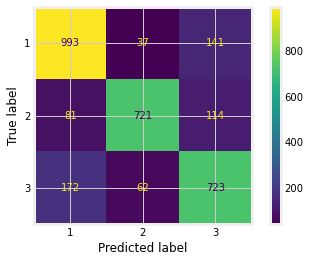

In [240]:
#random forest
plot_confusion_matrix(rf2, X2_te, y2_te)
## nice predictions, still many misclassified

In [241]:
# # initialize the output file object
# dot_data = StringIO() 

# # my fit DecisionTreeRegressor object here is: dtr1
# # for feature_names i put the columns of my Xr matrix
# export_graphviz(dtc2, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True,
#                 feature_names=X.columns)  

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
# graph.write_png('decision_tree_job_class.png')

# # # command not working - go look at png file to see decision tree
# # Image(graph.create_png())

In [242]:
rf2_features = pd.DataFrame()
rf2_features = pd.DataFrame([X2_tr.columns, rf2.feature_importances_]).T
rf2_features.rename(columns={0:'feature', 1:'coeff'}, inplace=True)

In [243]:
print(rf2_features.shape)
rf2_features.sort_values(by='coeff', ascending=False, inplace=True)
rf2_features.head(10)

(467, 2)


,feature,coeff
380,science,0.077318
105,data,0.036849
84,computer science,0.019388
83,computer,0.017621
223,intelligence,0.015827
367,research,0.013196
350,python,0.01178
26,architecture,0.011115
401,sql,0.010806
149,engineering,0.010344


In [244]:
rf2_features.tail(10)


,feature,coeff
67,collaborate,0.000743
126,disability,0.00074
407,strait,0.000735
173,fast paced,0.000729
3,aboriginal,0.000718
434,torres,0.000715
456,work closely,0.000711
435,torres strait,0.000709
5,aboriginal torres strait,0.000702
301,organisational,0.00068


<AxesSubplot:xlabel='coeff', ylabel='feature'>

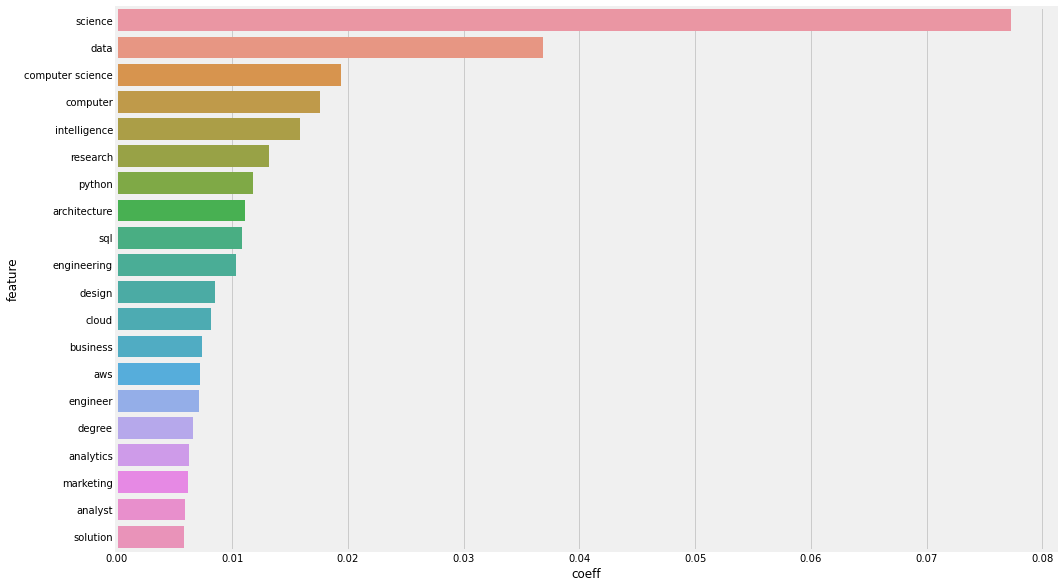

In [245]:
#plot top 20 features
plot_data = rf2_features[:20]
plt.figure(figsize=(15,10))
# plt.barh(y=plot_data.feature, width=plot_data.coeff)
sns.barplot(y=plot_data.feature, x=plot_data.coeff)

### Models: Logistic Regression & SVM

In [246]:
lr2 = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial')
lr2.fit(X2_tr, y2_tr)
y2_predict = lr2.predict(X2_te)
round(lr2.score(X2_te,y2_te), 4)

0.7293

In [247]:
svm_model2 = SVC(random_state=42)
svm_model2.fit(X2_tr, y2_tr)
# y2_hat = svm_model2.predict(X2_te)
round(svm_model2.score(X2_te, y2_te), 4)

0.7783

In [248]:
# SVM
confusion = pd.DataFrame(confusion_matrix(y2_te, y2_hat), 
                        index=['is_1', 'is_2', 'is_3'],
                        columns=[1,2,3])

print(classification_report(y2_te, y2_hat))
confusion

              precision    recall  f1-score   support

           1       0.80      0.85      0.82      1171
           2       0.88      0.79      0.83       916
           3       0.74      0.76      0.75       957

    accuracy                           0.80      3044
   macro avg       0.81      0.80      0.80      3044
weighted avg       0.80      0.80      0.80      3044



,1,2,3
is_1,993,37,141
is_2,81,721,114
is_3,172,62,723


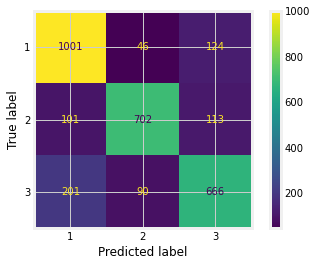

In [249]:
# SVM
plot_confusion_matrix(svm_model2, X2_te, y2_te)

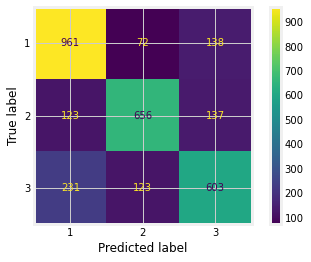

In [250]:
# logistic regression
plot_confusion_matrix(lr2, X2_te, y2_te)

#### Results: job classification
Good results for all casses. Choose Random Forest as prefered model >> good True Postives and low False Negatives.